# Проект Обучение с учителем: качество модели:<br>**«Персонализация предложений»**

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий.

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

Данные для работы находятся в нескольких таблицах.

**market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (**целевой признак**): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

**market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

**money.csv**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

# Подготовка

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import shap
from phik import phik_matrix
from matplotlib.axes import Axes

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## ШАГ 1. Загрузка данных

### Загрузка данных

In [4]:
market_file_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', delimiter=';', decimal=',')

In [5]:
def unique_objects(df: pd.DataFrame) -> None:

    """
    Функция для показа уникальных объектов во всех признаках
    типа данных object, для помощи в поиске неявных дубликатов
    """

    for col in df:
        if df[col].dtypes == 'object':
            print(df.groupby(by=col).size())
            print('___________________________')

In [6]:
def my_hist_plot(df: pd.DataFrame,
                 column: str,
                 title: str = None,
                 bins: int = 30,
                 x_label: str = "Количество",
                 y_label: str = "Покупатели") -> None:

    """
    Функция для отрисовки histplot, boxplot и вывода
    общей информации (describe()) для конкретного признака
    переданного DataFrame, на одном графике.
    """

    data = df[column]

    if title == None:
        title = (column.replace("_", " ")).title()

    fig, axs = plt.subplots(
        2, 2,
        figsize=(16, 5),
        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [3, 1]}
        )

    axs[0, 0].hist(data, bins=bins, color=sns.color_palette('BuGn_r')[2])
    axs[0, 0].xaxis.set_visible(False)
    axs[0, 0].set_ylabel(y_label)
    axs[0, 0].set_title(title)


    description = data.describe().to_string()
    axs[0, 1].text(0.7, 0.5, description, fontsize=14, ha="right", va="center")
    axs[0, 1].axis("off")

    sns.boxplot(data, ax=axs[1, 0], orient="h", color=sns.color_palette('BuGn_r')[3])
    axs[1, 0].set_xlabel(x_label)
    axs[1, 0].yaxis.set_visible(False)

    axs[1, 1].axis("off")

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [7]:
def my_pie_plot(data: pd.DataFrame,
                column: str,
                title: str = None,
                figsize: tuple = (7, 7)) -> None:

    """
    Функция для отрисовки одного pieplot для конкретного
    признака переданного DataFrame.
    """

    if title == None:
        title = (column.replace("_", " ")).title()

    data = data.groupby(by=column).size()
    plt.figure(figsize=figsize)
    plt.pie(data,
            autopct="%1.0f%%",
            labels=data.index,
            wedgeprops={'width': 0.2},
            colors=sns.color_palette('BuGn_r')[2:])
    plt.text(0, 0,
            title,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)

In [8]:
def my_bar_plot(data: pd.DataFrame, x: str, y: str,
                sort: bool = False, ascending: bool = False,
                title: str = None, label: str = None) -> None:

    """
    Функция для отрисовки barplot для конкретного
    признака переданного DataFrame.
    """

    if title == None:
        title = (x.replace("_", " ")).title()

    if label == None:
        label = (y.replace("_", " ")).title()

    data = data.groupby(by=x).sum()

    if sort == True:
        data = data.sort_values(by=y, ascending=ascending)

    plt.figure(figsize=(12, 5))

    sns.barplot(data=data, x=x, y=y, hue=x, palette='BuGn_r')

    plt.xlabel("Количество")
    plt.ylabel(label)
    plt.title(title,  fontdict = {'fontsize': 14})

    plt.show()

In [9]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Вывод

Были получены 4 таблицы, пропуски не обнаружены, требуется приведение названия признаков в единый формат.

## Шаг 2. Предобработка данных

### Предобработка market_file_df

In [13]:
market_file_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [14]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Приведение названий признаков к snake_case

In [15]:
market_file_df.columns = map(str.lower, market_file_df.columns)
market_file_df.columns = market_file_df.columns.str.replace(' ', '_')

Поиск явных дубликатов:

In [16]:
market_file_df.duplicated().sum()

0

Поиск неявных дубликатов:

In [17]:
unique_objects(market_file_df)

покупательская_активность
Прежний уровень    802
Снизилась          498
dtype: int64
___________________________
тип_сервиса
премиум      376
стандарт     914
стандартт     10
dtype: int64
___________________________
разрешить_сообщать
да     962
нет    338
dtype: int64
___________________________
популярная_категория
Домашний текстиль                       251
Косметика и аксесуары                   223
Кухонная посуда                         138
Мелкая бытовая техника и электроника    174
Техника для красоты и здоровья          184
Товары для детей                        330
dtype: int64
___________________________


In [18]:
market_file_df['тип_сервиса'] = market_file_df['тип_сервиса'].replace('стандартт', 'стандарт')

In [19]:
unique_objects(market_file_df)

покупательская_активность
Прежний уровень    802
Снизилась          498
dtype: int64
___________________________
тип_сервиса
премиум     376
стандарт    924
dtype: int64
___________________________
разрешить_сообщать
да     962
нет    338
dtype: int64
___________________________
популярная_категория
Домашний текстиль                       251
Косметика и аксесуары                   223
Кухонная посуда                         138
Мелкая бытовая техника и электроника    174
Техника для красоты и здоровья          184
Товары для детей                        330
dtype: int64
___________________________


In [20]:
market_file_df.duplicated().sum()

0

Дубликатов нет.

### Предобработка market_money_df

In [21]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [22]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Приведение названий признаков к snake_case

In [23]:
market_money_df.columns = map(str.lower, market_money_df.columns)

Поиск явных дубликатов:

In [24]:
market_money_df.duplicated().sum()

0

Поиск неявных дубликатов:

In [25]:
unique_objects(market_money_df)

период
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
dtype: int64
___________________________


Дубликатов нет.

### Предобработка market_time_df

In [26]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [27]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Приведение названий признаков к snake_case

In [28]:
market_time_df.columns = map(str.lower, market_time_df.columns)

Поиск явных дубликатов:

In [29]:
market_time_df.duplicated().sum()

0

Поиск неявных дубликатов:

In [30]:
unique_objects(market_time_df)

период
предыдцщий_месяц    1300
текущий_месяц       1300
dtype: int64
___________________________


Исправление опечатки у значений "предыд**ц**щий_месяц"

In [31]:
market_time_df['период'] = market_time_df['период'].replace('предыдцщий_месяц',
                                                            'предыдущий_месяц')

In [32]:
unique_objects(market_time_df)

период
предыдущий_месяц    1300
текущий_месяц       1300
dtype: int64
___________________________


In [33]:
market_time_df.duplicated().sum()

0

Дубликатов нет.

### Предобработка money_df

In [34]:
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [35]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Приведение названий признаков к snake_case

In [36]:
money_df.columns = map(str.lower, money_df.columns)

Поиск явных дубликатов:

In [37]:
money_df.duplicated().sum()

0

Дубликатов нет.

### Вывод

Названия столбцов были приведены к snake_case, были исправлены опкчатки, дубликаты не обнаружены.

## Шаг 3. Исследовательский анализ данных

In [38]:
market_money_df

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


### Подготовка данных

Создадим фрейм с id пользователей, чья покупательская активность сохранялась на протяжении всех трех послдених месяцев:

In [39]:
suit_buyers = market_money_df.query('выручка > 0')['id'].value_counts().reset_index()

In [40]:
suit_buyers = suit_buyers.query('count > 2').set_index('id')

In [41]:
suit_buyers.count()

,0
count,1297


1297 из 1300 пользователей совершали покупки в каждом из трех месяцев

Удалим не подходящих пользователей из датафреймов:

In [42]:
market_file_df = market_file_df[market_file_df.id.isin(suit_buyers.index)]

In [43]:
market_file_df.shape

(1297, 13)

In [44]:
market_money_df = market_money_df[market_money_df.id.isin(suit_buyers.index)]

In [45]:
market_money_df.shape

(3891, 3)

In [46]:
market_time_df = market_time_df[market_time_df.id.isin(suit_buyers.index)]

In [47]:
market_time_df.shape

(2594, 3)

In [48]:
money_df = money_df[money_df.id.isin(suit_buyers.index)]

In [49]:
money_df.shape

(1297, 2)

### Исследовательский анализ market_file_df

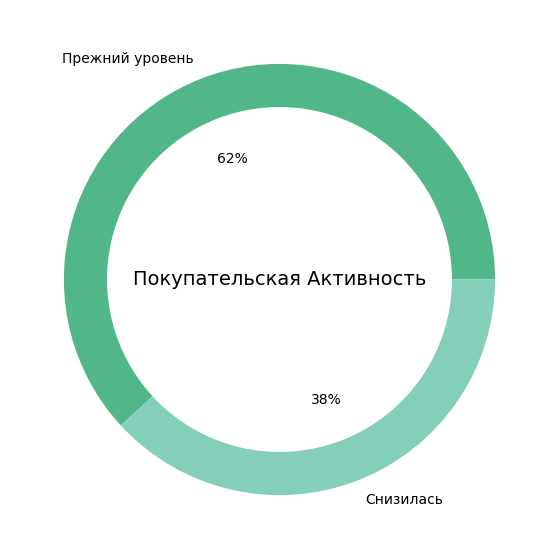

In [50]:
my_pie_plot(market_file_df, 'покупательская_активность')

У 38% пользователей снизилась акивность за послдение 3 месяца.

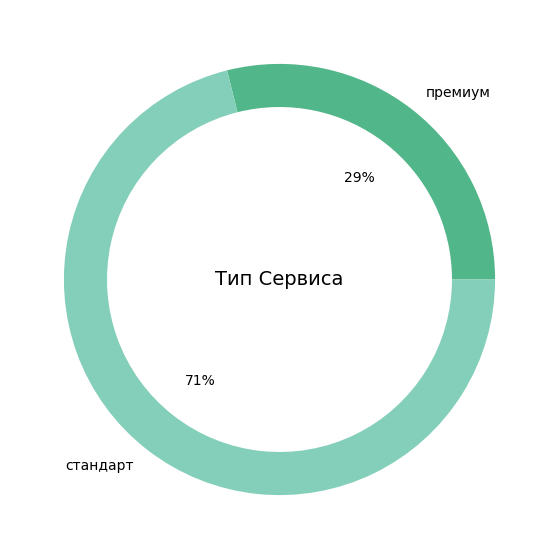

In [51]:
my_pie_plot(market_file_df, 'тип_сервиса')

У 71% пользователей тип сервиса Стандарт, у 29% Премиум.

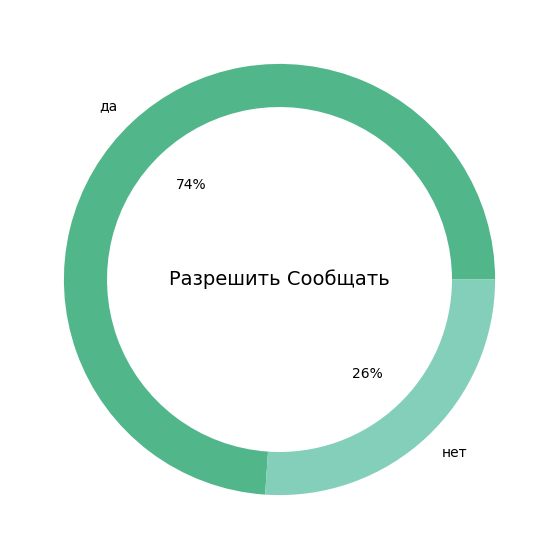

In [52]:
my_pie_plot(market_file_df, 'разрешить_сообщать')

74% покупателей дали свое согласие на дополнительные рассылки предложений товаров

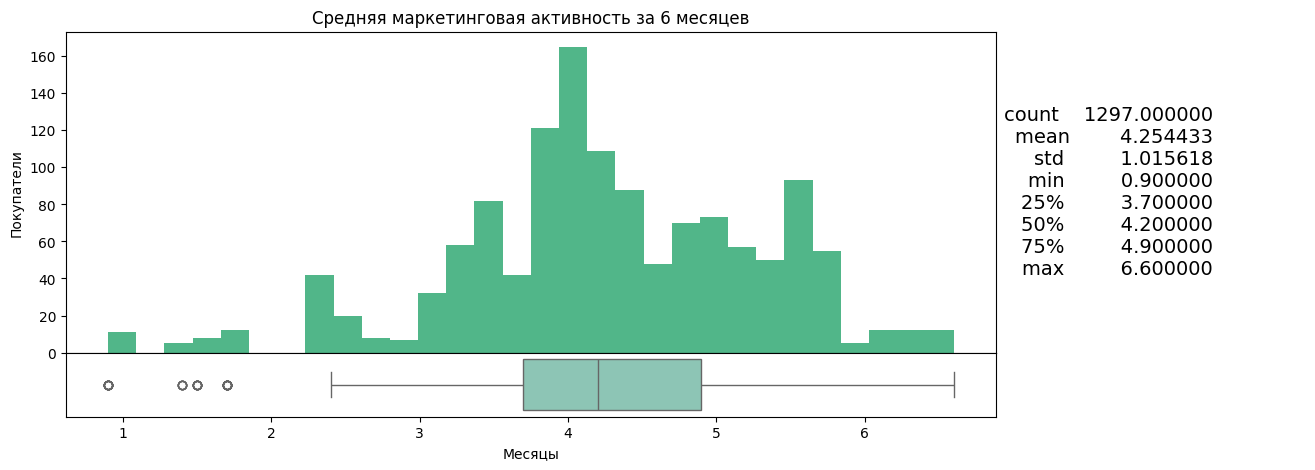

In [53]:
my_hist_plot(market_file_df, 'маркет_актив_6_мес', title='Средняя маркетинговая активность за 6 месяцев', x_label="Месяцы")

В среднем за 6 месяцев, пользователи получают по 4,25 маркетинговых предложения в месяц. Есть небольшой выброс пользователей, которые получают меньше двух сообщений в месяц.

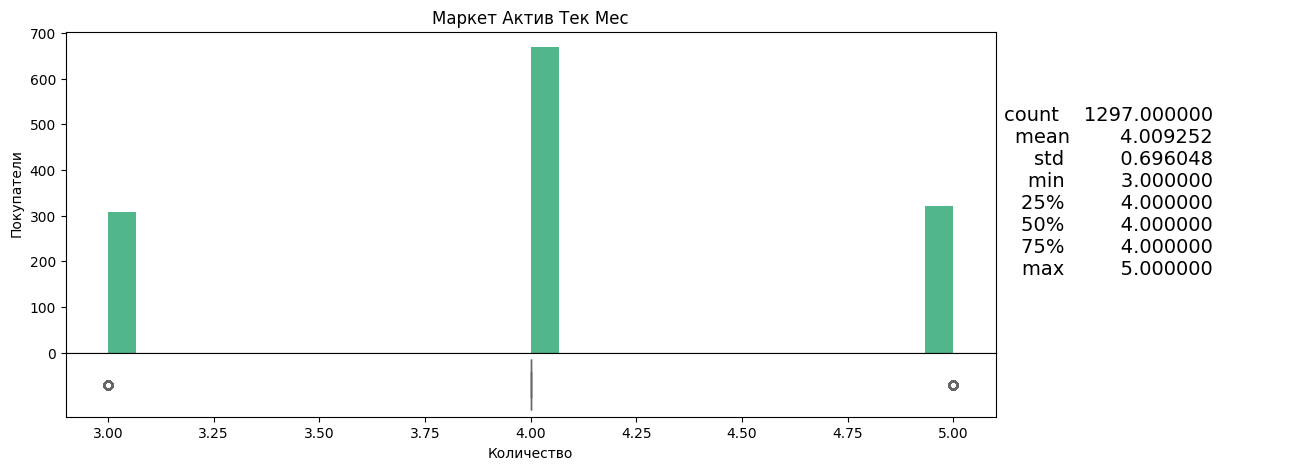

In [54]:
my_hist_plot(market_file_df, 'маркет_актив_тек_мес')

У признака `маркет_актив_тек_мес` всего лишь 3 значения, можно построить круговую диаграмму, в дальнейшем может иметь смысл перевести в тип данных object:

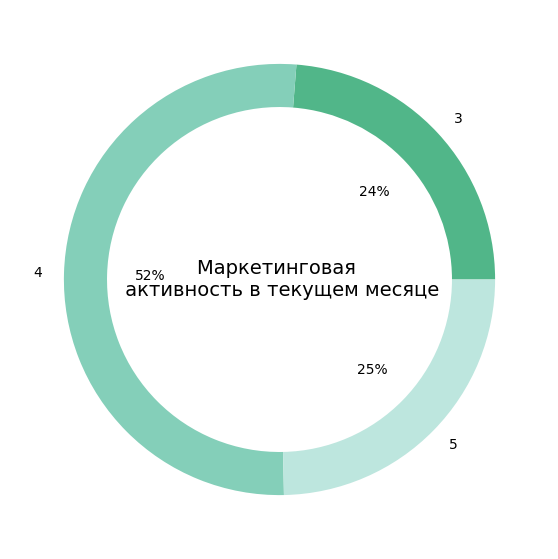

In [55]:
my_pie_plot(market_file_df, 'маркет_актив_тек_мес',  title='Маркетинговая \n активность в текущем месяце')

Почти ровно половина пользователей в текущем месяце получили по 4 маркетинговых сообщения и 25% и 24% по 3 и 5 сообщений соответственно.

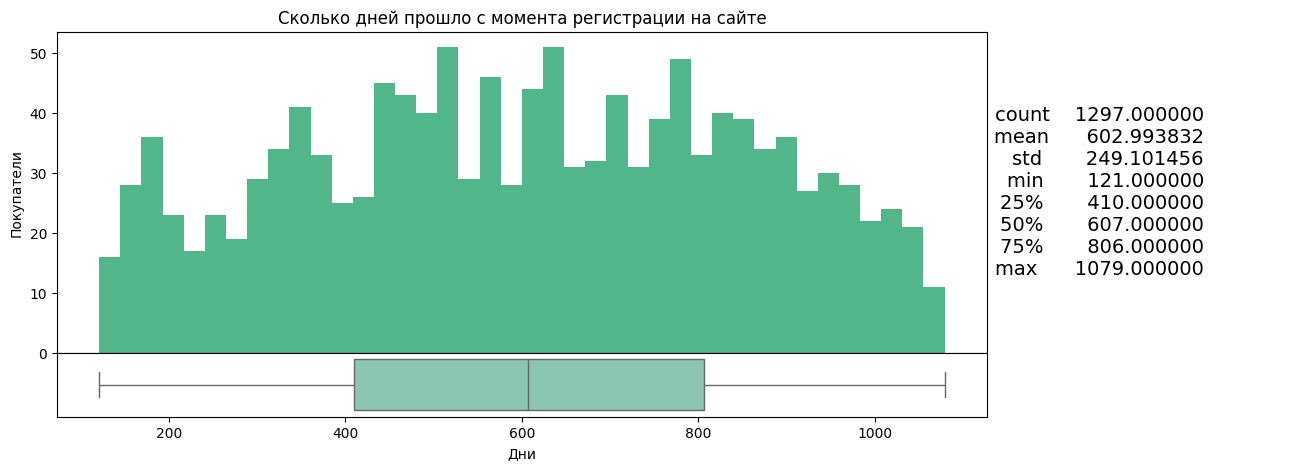

In [56]:
my_hist_plot(market_file_df, 'длительность', bins=40, title='Cколько дней прошло с момента регистрации на сайте', x_label='Дни')

Пик регистраций приходиться в районе от 500 до 700 дней, в более позднее время количество регистраций снижается. Приблизительно каждые 150 дней наблюдаются всплески регистраций, возможно есть сезонная зависимость.

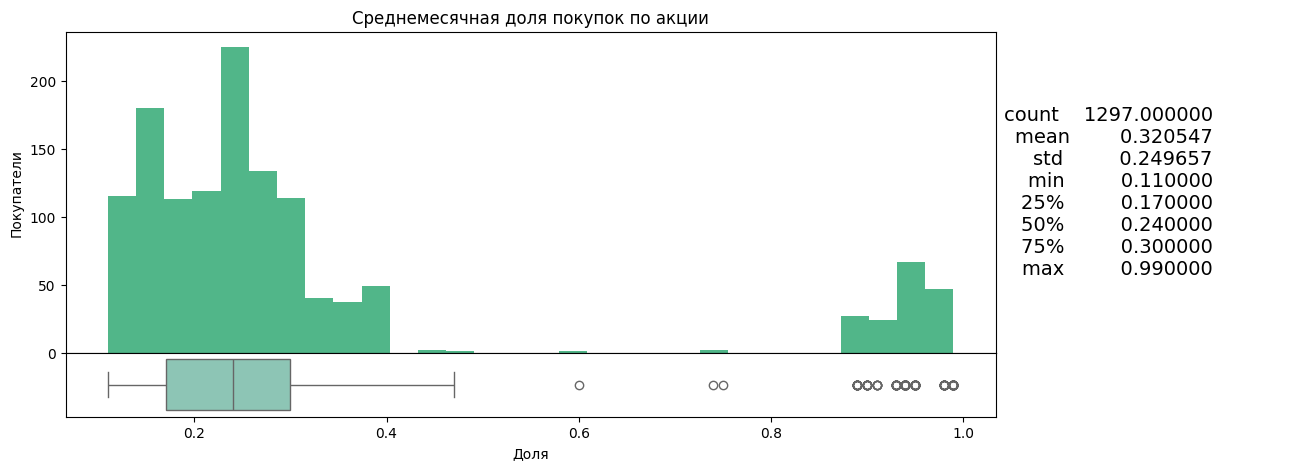

In [57]:
my_hist_plot(market_file_df, 'акционные_покупки', title='Cреднемесячная доля покупок по акции', x_label='Доля')

In [58]:
market_file_df.query('акционные_покупки > 0.8')['акционные_покупки'].count()/len(market_file_df)

0.1272166538164996

На графике выделяется 2 группы покупателей, первая, самая большая группа, около 87% пользователей, в среднем покупают 25% товаров по акции, вторая группа, 13% пользователей имеют долю покупок по акции от 80% до 98%.

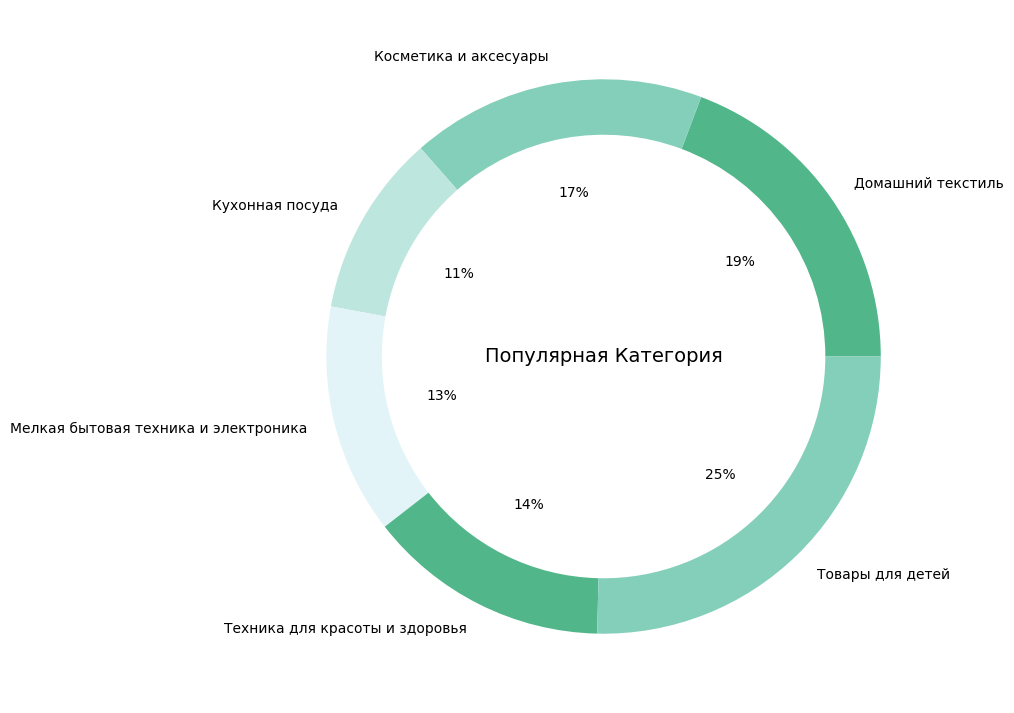

In [59]:
my_pie_plot(market_file_df, 'популярная_категория', figsize=(9, 9))

Товары для детей занимают четверть всех покупок пользователей, вторая по популярености категория "Домашний текстиль" - 19%, третья "Косметика и аксесуары" - 17%. Самая не популярная категория "Кухонная посуда" - 11%.

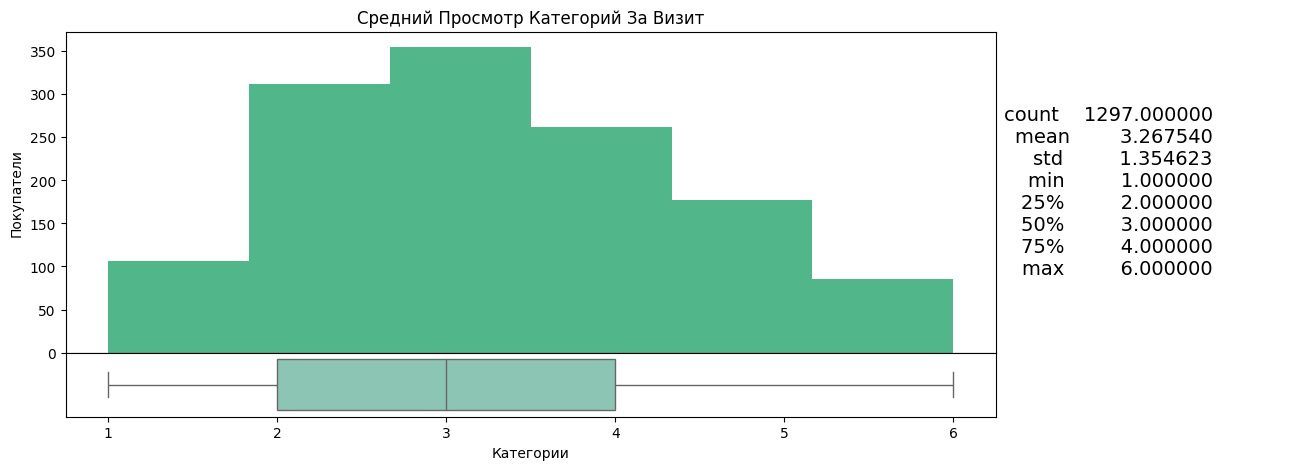

In [60]:
my_hist_plot(market_file_df, 'средний_просмотр_категорий_за_визит', x_label='Категории', bins=6)

Покупатели в среднем просматривают по 3 категории товаров за один визит на сайт.

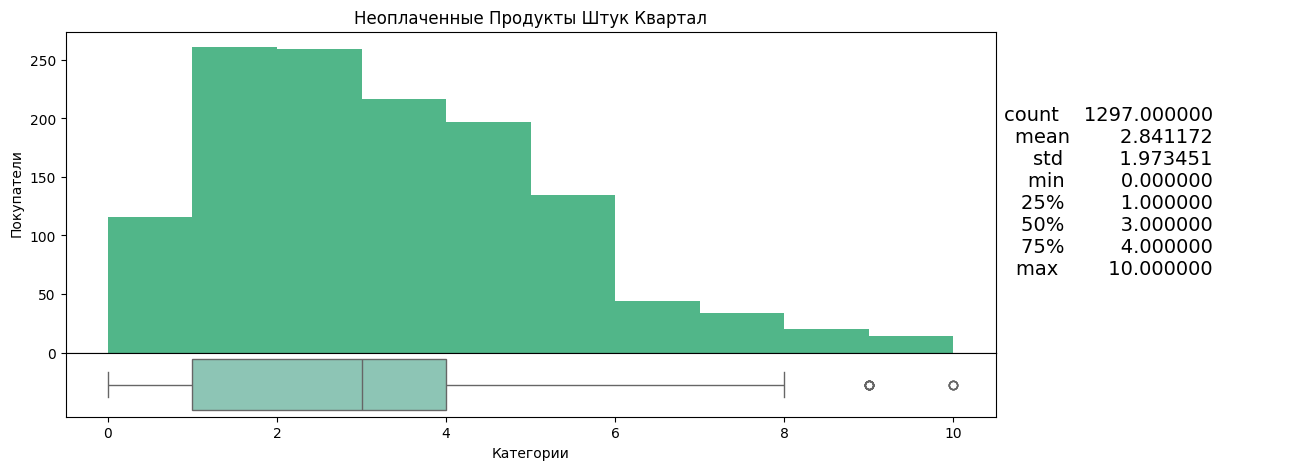

In [61]:
my_hist_plot(market_file_df, 'неоплаченные_продукты_штук_квартал', x_label='Категории', bins=10)

Обычно люди держат не оплаченными в корзине 2-3 товара, в очень редких случаях 8-10 товаров.

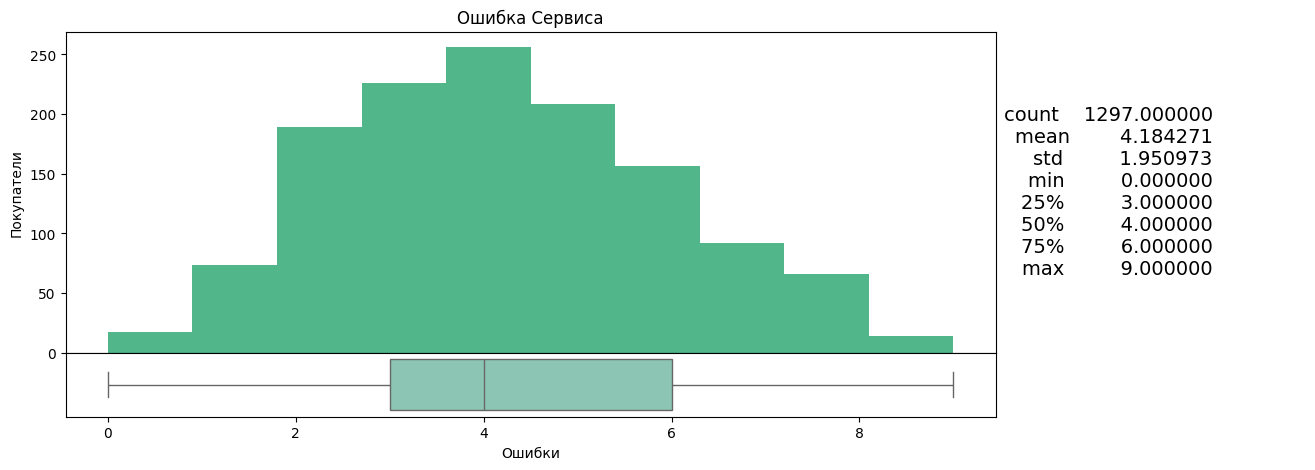

In [62]:
my_hist_plot(market_file_df, 'ошибка_сервиса', x_label='Ошибки', bins=10)

Покупатели встречались с ошибками сервиса, в среднем, по 4 раза, максимальный показатель - 9 раз.

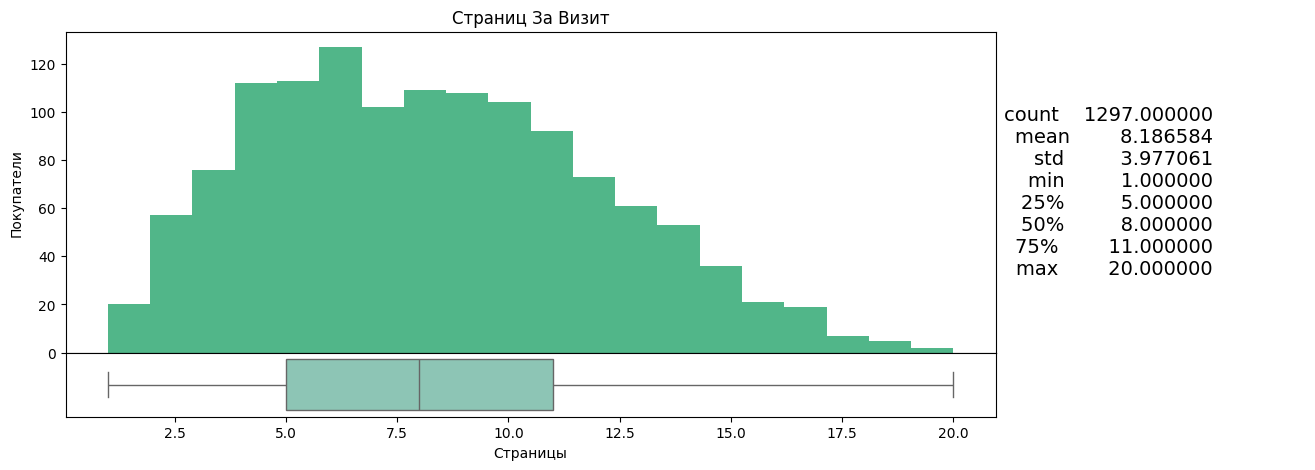

In [63]:
my_hist_plot(market_file_df, 'страниц_за_визит', x_label='Страницы', bins=20)

За последние 3 месяца, средний покупатель просматривал по 8 страниц за один заход на сайт.

### Исследовательский анализ market_money_df

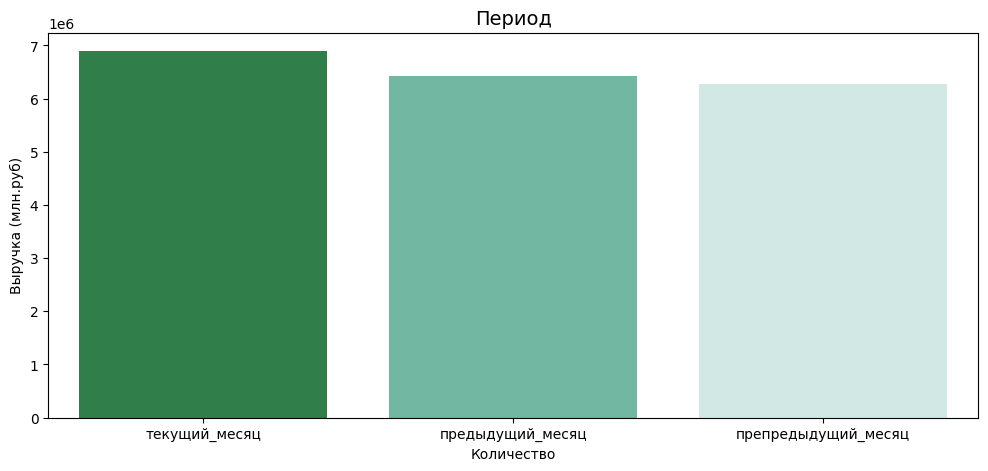

In [64]:
my_bar_plot(market_money_df, 'период', 'выручка', sort=True, label='Выручка (млн.руб)')

Общая выручка растет каждый месяц.

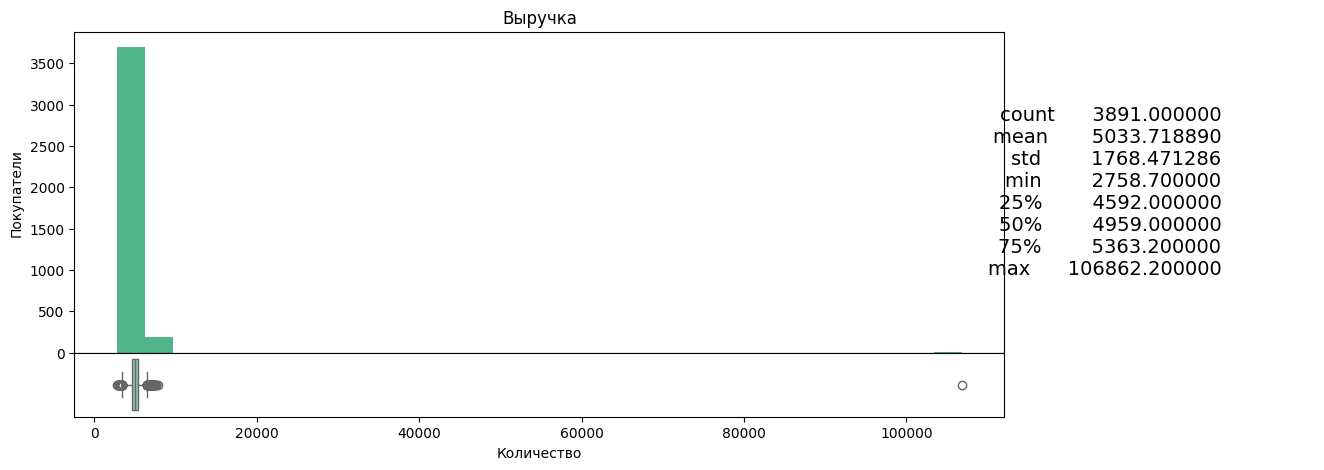

In [65]:
my_hist_plot(market_money_df, 'выручка')

In [66]:
market_money_df.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


На графике есть огромный выброс, один пользователь купил за месяц товаров на 106862 рубля, при среднем показателе в 5 тысяч, в дальнейшем этот выброс нужно удалить.


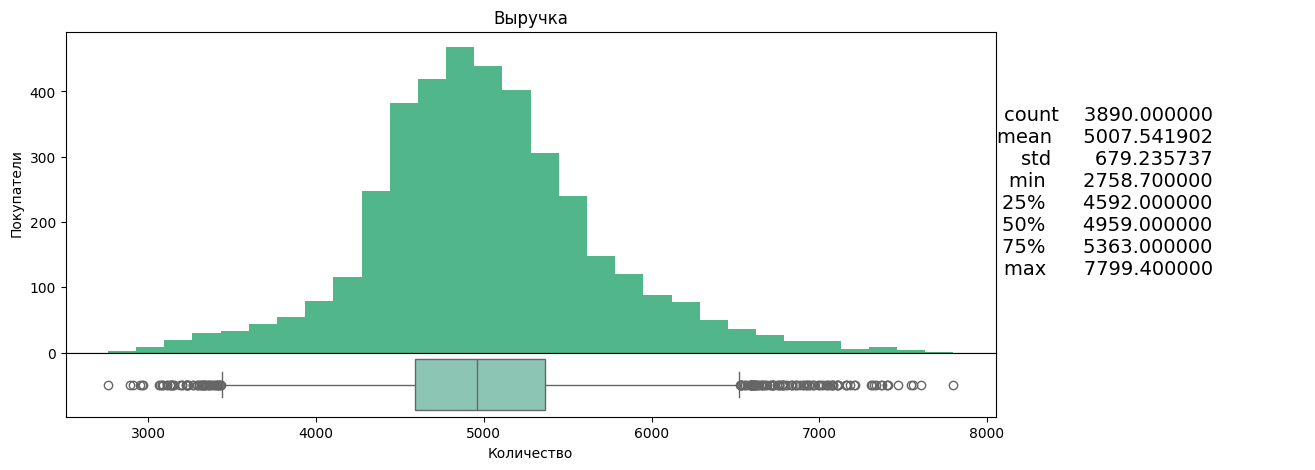

In [67]:
my_hist_plot(market_money_df.query('выручка < 100000'), 'выручка')

Данные по выручке распределены нормально, со средним в 5 тысяч рублей, есть не значительные выбросы в меньшую и в большую сторону, стандартное отклонение 679.

### Исследовательский анализ market_time_df

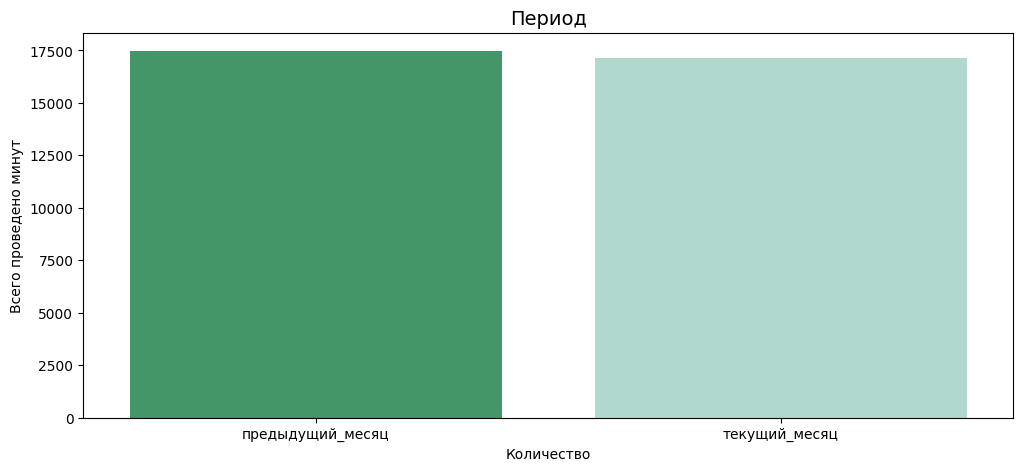

In [68]:
my_bar_plot(market_time_df, 'период', 'минут', sort=True, label='Всего проведено минут')

Пользователи стабильно проводят на сайте приблизительно 17500 минут в каждый из двух месяцев.

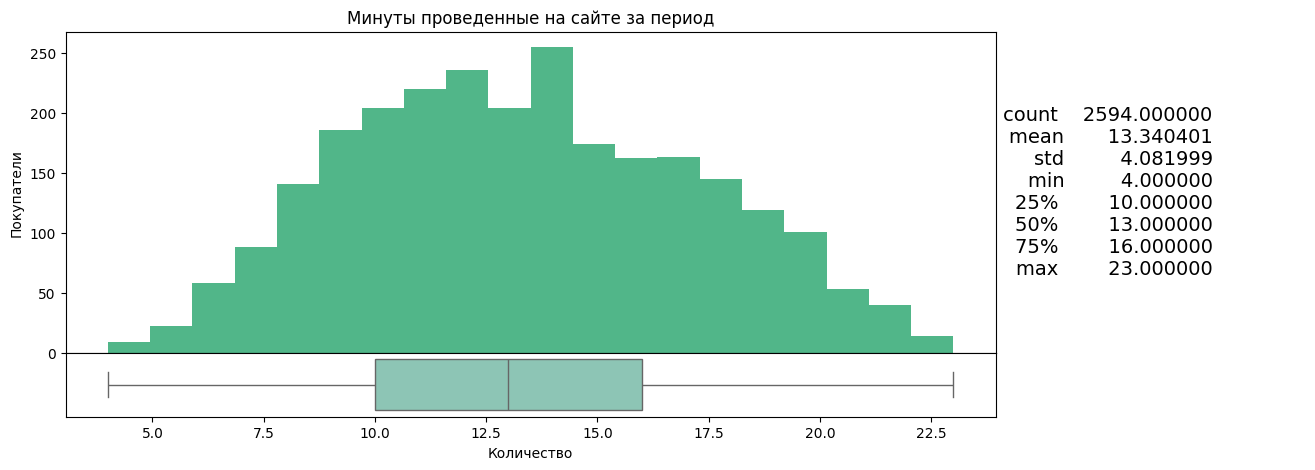

In [69]:
my_hist_plot(market_time_df, 'минут', bins=20, title='Минуты проведенные на сайте за период')

Пользователи проводили на сайте в среднем по 13 минут.

### Исследовательский анализ money_df

In [70]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1297 non-null   int64  
 1   прибыль  1297 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


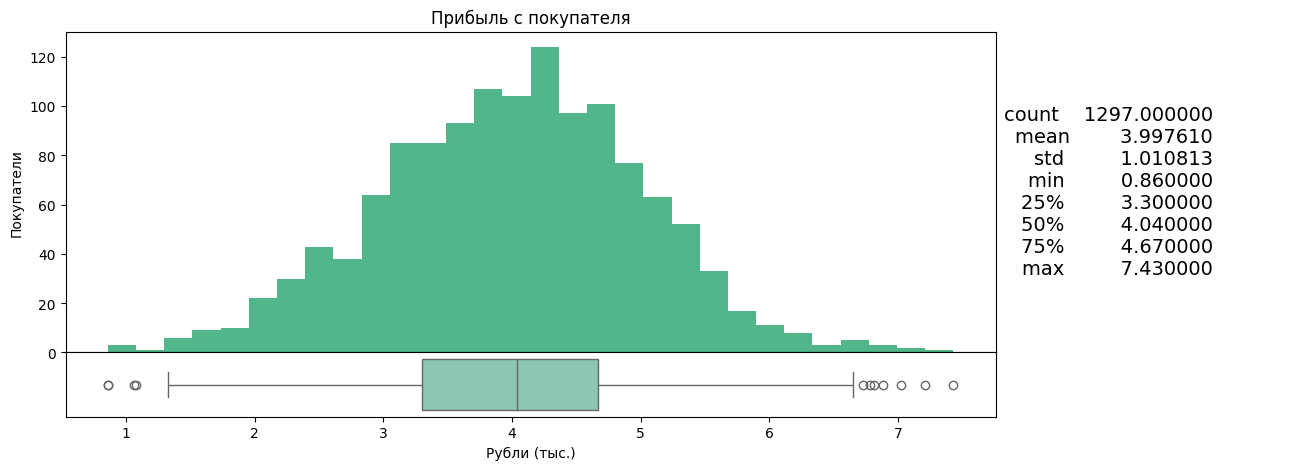

In [71]:
my_hist_plot(money_df, 'прибыль', title='Прибыль с покупателя', x_label='Рубли (тыс.)')

В среднем каждый пользователь за 3 месяца приносит 4 тысячи рублей прибыли

### Вывод

У 38% пользователей снизилась акивность за послдение 3 месяца. Почти треть покупателей имеет тип сервиса Премиум, 74% покупателей дали свое согласие на дополнительные рассылки. В среднем за 6 месяцев, пользователи получают по 4,25 маркетинговых предложения в месяц, но в последнем месяце наблюдается снижение до 4 сообщений.

Больше всего регистраций пришлось в районе между 500 и 700 дней назад, в более позднее время количество регистраций снижается. Приблизительно каждые 150 дней наблюдаются всплески регистраций, возможно есть сезонная зависимость.

Можно выделить 2 группы покупателей, первая, около 87% пользователей, в среднем покупают 25% товаров по акции, вторая группа, 13% пользователей имеют долю покупок по акции от 80% до 98%.

Товары для детей занимают четверть всех покупок пользователей, вторая по популярености категория "Домашний текстиль", третья "Косметика и аксесуары".

Покупатели в среднем просматривают по 3 категории товаров за один визит на сайт. Обычно люди держат не оплаченными в корзине 2-3 товара. Покупатели встречались с ошибками сервиса, в среднем, по 4 раза. За последние 3 месяца, средний покупатель просматривал по 8 страниц за один заход на сайт.

Общая выручка растет каждый месяц. В среднем каждый пользователь за 3 месяца приносит 4 тысячи рублей прибыли. Все пользователи стабильно проводят на сайте приблизительно 17500 минут в каждый из двух месяцев. Каждый пользователь проводил на сайте в среднем по 13 минут.

## Шаг 4. Объединение таблиц

Объединение таблиц:

In [72]:
market_file_df = market_file_df.set_index('id')

In [73]:
market_money_df = market_money_df.set_index('id')

In [74]:
market_time_df = market_time_df.set_index('id')

In [75]:
main_df = market_file_df.copy(deep=True)

In [76]:
main_df['текущий_месяц_выручка'] = market_money_df[market_money_df['период'] == 'текущий_месяц']['выручка']

In [77]:
main_df['предыдущий_месяц_выручка'] = market_money_df[market_money_df['период'] == 'предыдущий_месяц']['выручка']

In [78]:
main_df['препредыдущий_месяц_выручка'] = market_money_df[market_money_df['период'] == 'препредыдущий_месяц']['выручка']

In [79]:
main_df['текущий_месяц_минут'] = market_time_df[market_time_df['период'] == 'текущий_месяц']['минут']

In [80]:
main_df['предыдущий_месяц_минут'] = market_time_df[market_time_df['период'] == 'предыдущий_месяц']['минут']

Удалим выброс с большой выручкой, выявленный на этапе иследовательского анализа:

In [81]:
main_df = main_df.drop(215380, axis=0)

In [82]:
main_df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [83]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

In [84]:
main_df.shape

(1296, 17)

## Шаг 5. Корреляционный анализ

Проведем корреляционный анализ на основе матрицы корреляыии phik:

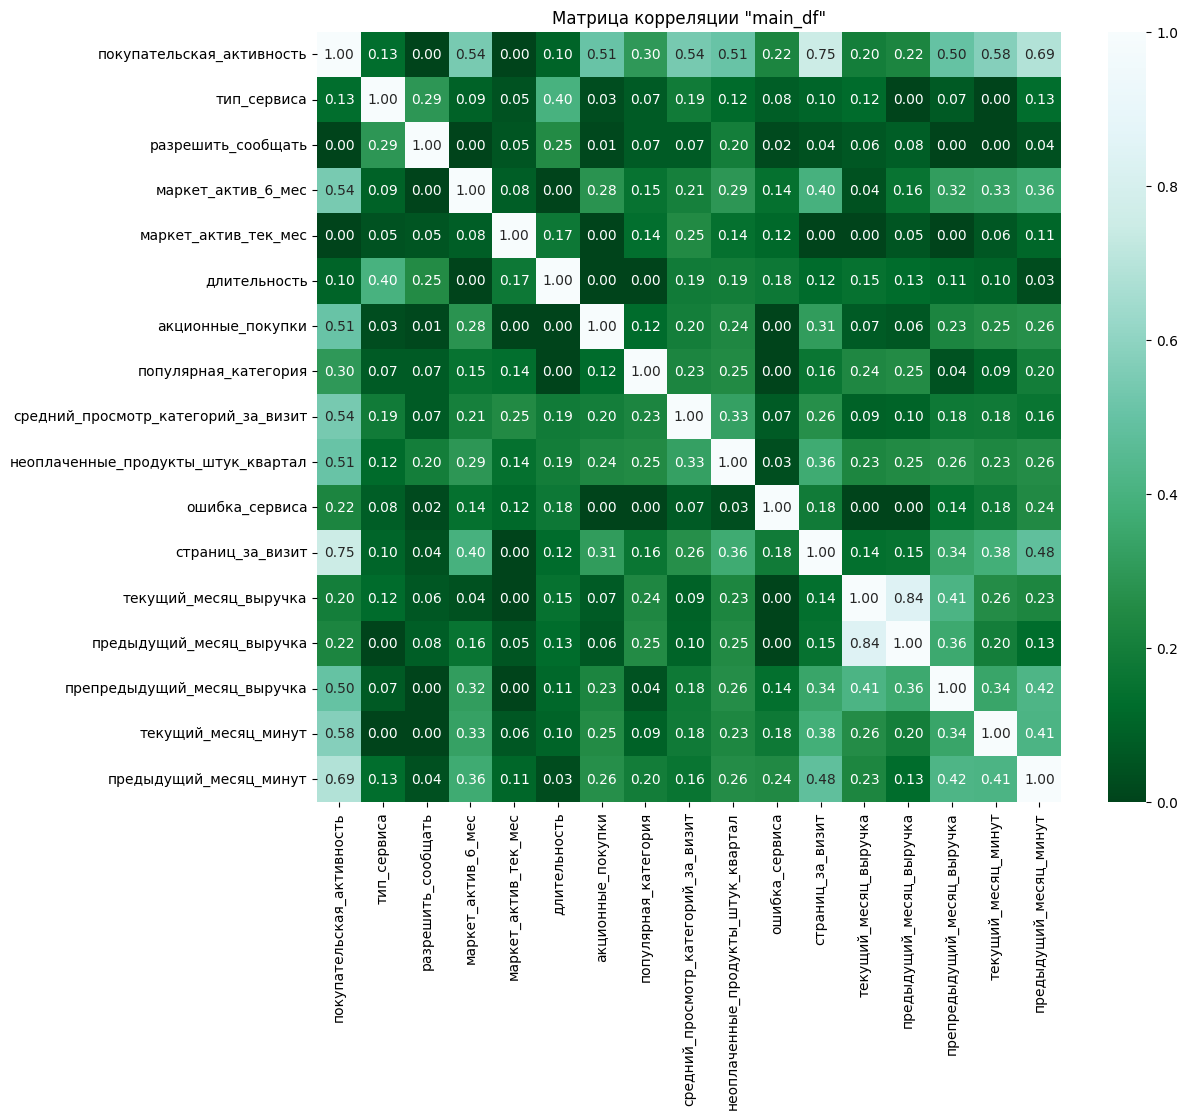

In [85]:
plt.figure(figsize=(12,10), dpi= 100)
sns.heatmap(main_df.phik_matrix(
    interval_cols=[
        'маркет_актив_6_мес',
        'маркет_актив_тек_мес',
        'длительность',
        'акционные_покупки',
        'средний_просмотр_категорий_за_визит',
        'неоплаченные_продукты_штук_квартал',
        'ошибка_сервиса',
        'страниц_за_визит',
        'текущий_месяц_выручка',
        'предыдущий_месяц_выручка',
        'препредыдущий_месяц_выручка',
        'текущий_месяц_минут',
        'предыдущий_месяц_минут'
        ]
), annot = True, fmt=".2f", cmap='BuGn_r')
plt.title('Матрица корреляции "main_df"',  fontdict = {'fontsize': 12})
plt.show()

### Вывод

Целевой признак `покупательская_активность` имеет высокую корреляцию с признаком `страниц_за_визит` - 0.75, так же имеет среднюю корреляцию с признаком `предыдущий_месяц_минут` - 0.69. Среднюю корреляцию с `текущий_месяц_минут` - 0.58, `маркет_актив_6_мес` - 0.54 и заметную с `неоплаченные_продукты_штук_квартал` и `акционные_покупки` по 0.51. Слабо коррелирует с `текущий_месяц_выручка`, `препредыдущий_месяц_выручка`, `длительность`, `тип_сервиса` и `ошибка_сервиса`. Не коррелирует с `маркет_актив_тек_мес`, `разрешить_сообщать`.

## Шаг 6. Использование пайплайнов

В данной бизнес задаче, нельзя упустить клиентов, чья активность снижается, чтобы бизнес мог вовремя предпринять меры, тоесть нужно избежать ошибки FN, когда не верно присваевается класс 1 ("Снизилась"), значит надо использовать метрику Recall.

In [86]:
main_df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


Уберем из тренировочной выбоки признаки с отсутствующей или очень низкой корреляцией с целевым признаком и сам целевой признак, отталкиваясь от таблицы phik из предыдущего шага:

In [87]:
low_corr = ['покупательская_активность',
            'текущий_месяц_выручка',
            'препредыдущий_месяц_выручка',
            'длительность',
            'тип_сервиса',
            'ошибка_сервиса',
            'маркет_актив_тек_мес',
            'разрешить_сообщать']

In [88]:
X = main_df.drop(low_corr, axis=1)

y = main_df['покупательская_активность']

y_ord = OrdinalEncoder(categories=[['Прежний уровень', 'Снизилась']])
y = y_ord.fit_transform(pd.DataFrame(y)).ravel()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)


ohe_columns = ['популярная_категория']
num_columns = ['маркет_актив_6_мес', 'акционные_покупки',
              'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'страниц_за_визит',
              'текущий_месяц_минут', 'предыдущий_месяц_минут']


# пайплайн для OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleimputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
    #  ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# финальный пайплайн
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
]
)

# модели и параметры
param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__max_features': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability= True)],
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)


randomized_search.fit(X_train, y_train);

In [89]:
print(randomized_search.best_score_)
print(randomized_search.best_estimator_)

0.7547027027027027
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['популярная_категория']),
                                                 ('num', 'passthrough',
                                                  ['маркет_актив_6_мес',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_шту

In [90]:
result = pd.DataFrame(randomized_search.cv_results_)
result[ ['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
3,1,"LogisticRegression(penalty='l1', random_state=...",0.754703,"{'preprocessor__num': 'passthrough', 'models__..."
8,2,"LogisticRegression(penalty='l1', random_state=...",0.752036,"{'preprocessor__num': 'passthrough', 'models__..."
5,3,DecisionTreeClassifier(random_state=42),0.744072,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,4,DecisionTreeClassifier(random_state=42),0.741261,"{'preprocessor__num': 'passthrough', 'models__..."
0,5,DecisionTreeClassifier(random_state=42),0.730559,"{'preprocessor__num': 'passthrough', 'models__..."
9,6,DecisionTreeClassifier(random_state=42),0.714198,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,7,DecisionTreeClassifier(random_state=42),0.711676,"{'preprocessor__num': 'passthrough', 'models__..."
6,8,DecisionTreeClassifier(random_state=42),0.690090,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,9,DecisionTreeClassifier(random_state=42),0.641514,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,10,KNeighborsClassifier(),0.323387,"{'preprocessor__num': 'passthrough', 'models__..."


In [91]:
y_pred = randomized_search.best_estimator_.predict(X_test)

In [92]:
y_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

accuracy: 0.91
recall: 0.82
f1: 0.87
roc_auc: 0.92
precision: 0.93


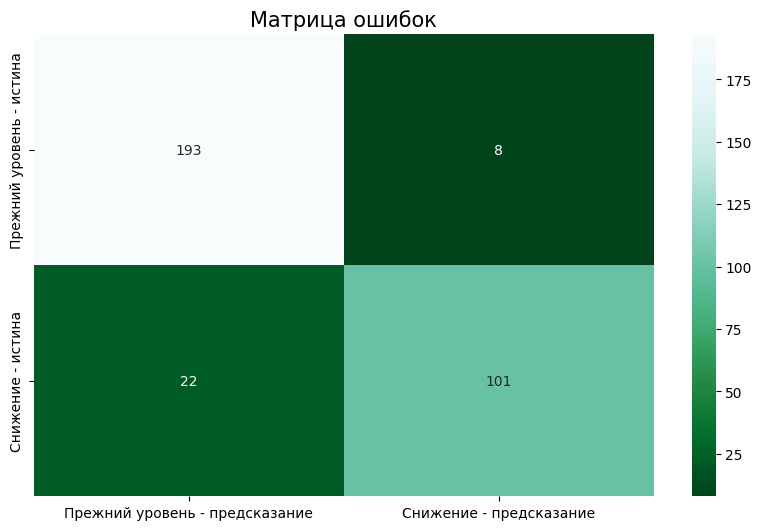

In [93]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print(f'accuracy: {round(accuracy, 2)}')
print(f'recall: {round(recall, 2)}')
print(f'f1: {round(f1, 2)}')
print(f'roc_auc: {round(roc_auc, 2)}')
print(f'precision: {round(precision, 2)}')

plt.figure(figsize=(10,6), dpi= 100)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot = True,
            fmt=".0f",
            cmap='BuGn_r',
            xticklabels=['Прежний уровень - предсказание','Снижение - предсказание'],
            yticklabels=['Прежний уровень - истина','Снижение - истина']
           )
plt.title('Матрица ошибок',  fontdict = {'fontsize' : 15})
plt.show()

### Вывод

По результатам обучения самая лучшая модель имеет recall равный 0,75. На тестовых данных recall получился 0,82, accuracy - 0.91, f1 - 0.87, roc_auc - 0.92, precision - 0.93. Метрики получились высокими, что говорит о том, что модель справляется хорошо. Важную для бизнеса метрику recall можно повысить за счет изменения порога вероятност присваивания класса, но в контексте данной задачи важно получить саму вероятность присвоения класса - predict_proba.

## Шаг 7. Анализ важности признаков

In [94]:
X_tarin_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_tarin_shap)
shap_values = explainer(X_tarin_shap)

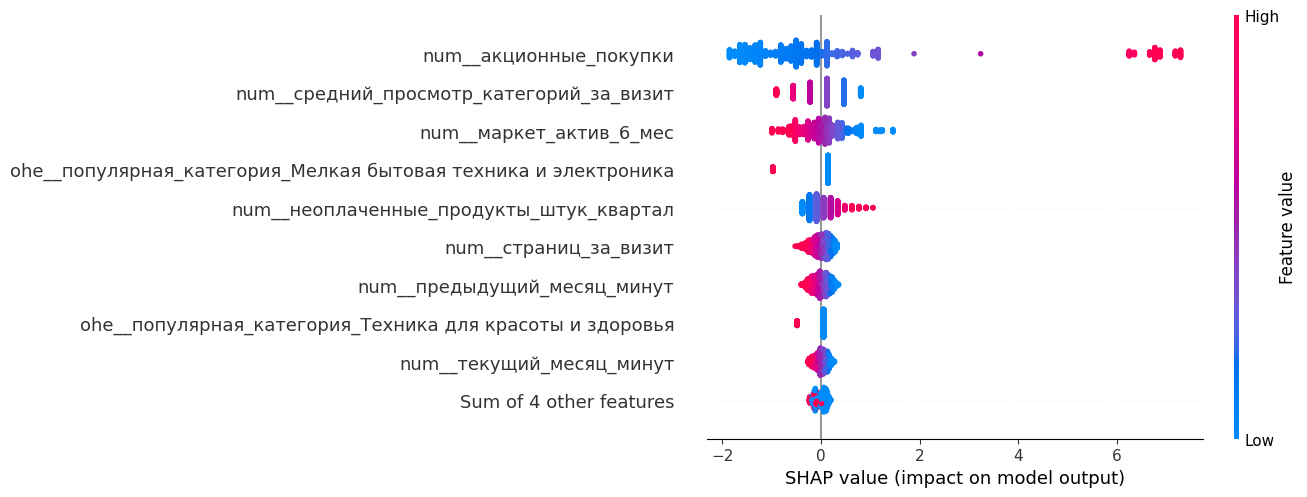

In [95]:
shap.plots.beeswarm(shap_values)

Самым важным признаком оказалась доля акционных покупок, на графике видно, что с увеличением этого показателя, модель сильно склоняется к присвоению класса 1 - снижение активности. На втором месте количество просмотренных категорий за визит, тут наоборот, чем выше показатель, тем сильнее модель склоняется к классу 0. На третьем месте маркетинговая активность за 6 месяцев, чем ниже активность, тем больше модель склоняется к присвоению первого класса.

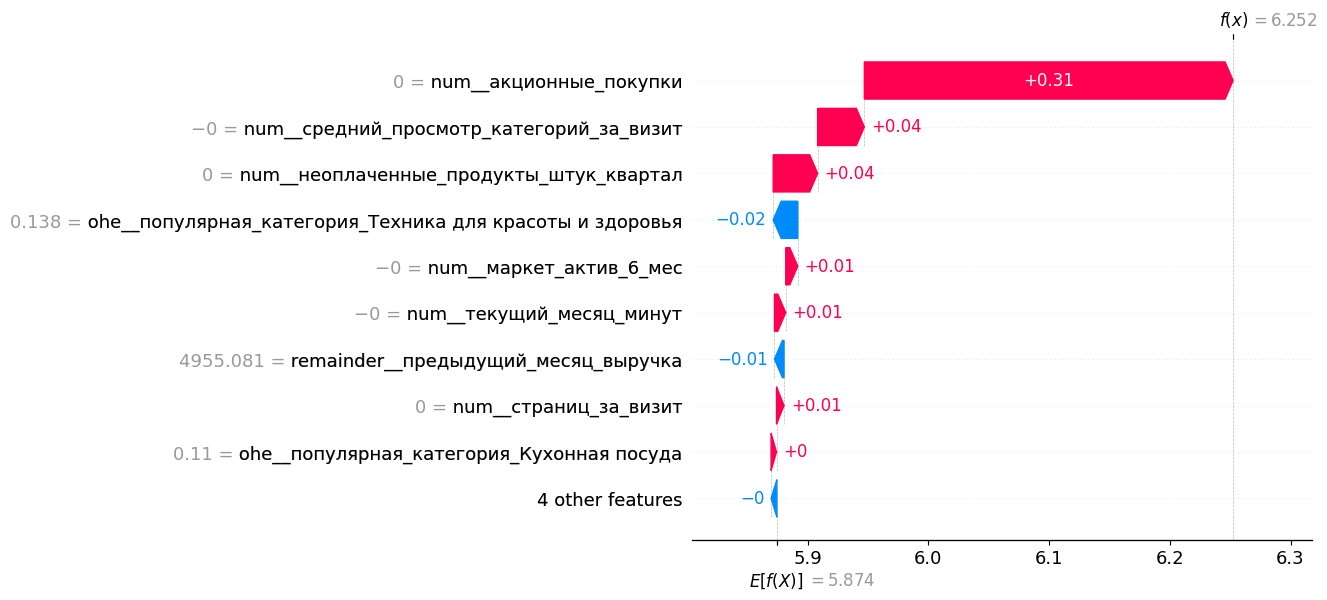

In [96]:
shap.plots.waterfall(shap_values[:].mean(axis=0))

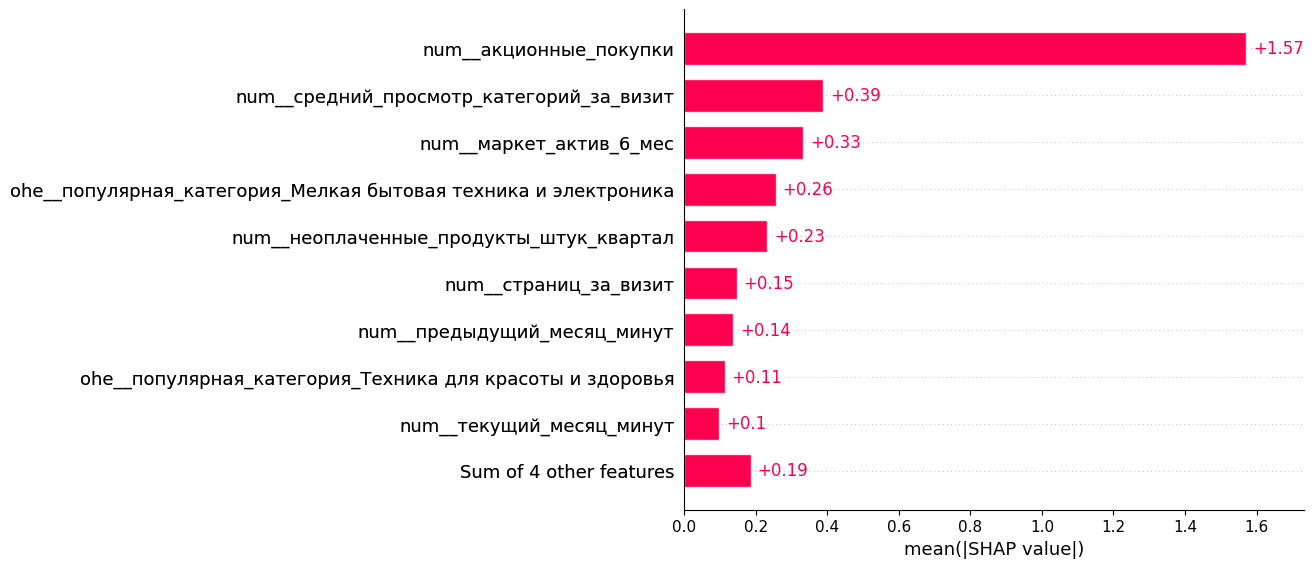

In [97]:
shap.plots.bar(shap_values)

Влияние признака `акционные_покупки` почти сопоставимо с влиянием всех остальных признаков, вместе взятых.

### Вывод

Признак `акционные_покупки` очень сильно влияет на присвоение первого класса, с его увеличением растет вероятность того, что активность пользователей снизится. На втором месте идет средний просмотр категорий за визит, чем больше просмотров тем выше вероятность сохранения активности, что логично. На третьем маркетинговая активность за 6 месяцев, чем реже покупатель получает расслки с предложениями, тем выше вероятность снижения активности.

## Шаг 8. Сегментация покупателей

Проведем исследованние сегмента клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. За основу возьмем датасет `X_test`, на котором модель на Шаге 6 посчитиала вроятности снижения активности - `y_pred_proba`

In [98]:
segmentation_df = X_test.copy(deep=True)

In [99]:
segmentation_df['вероятность_снижения_активности'] = y_pred_proba

In [100]:
segmentation_df = segmentation_df.merge(money_df, on='id')

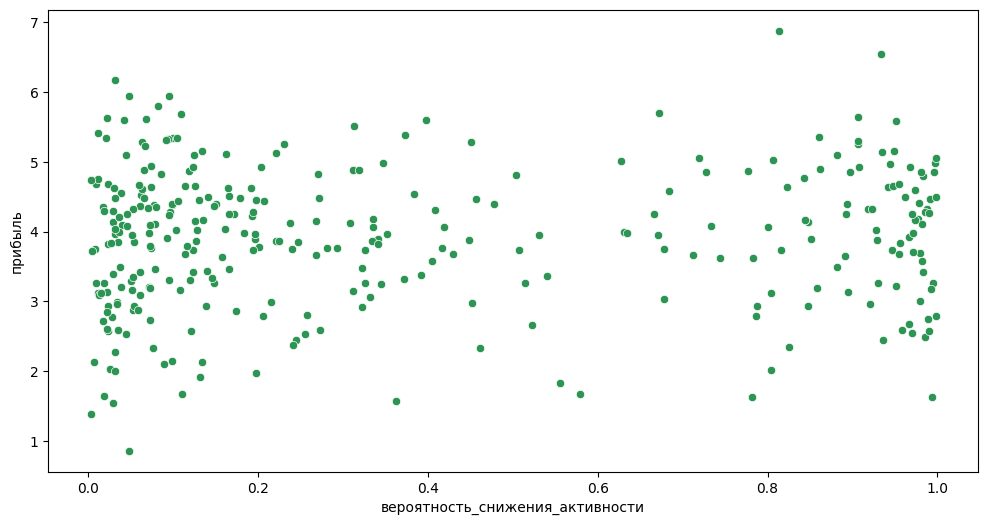

Средняя прибыль по всем пользователям: 3.9


In [101]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=segmentation_df,
                x='вероятность_снижения_активности',
                y='прибыль',
                color=sns.color_palette('BuGn_r')[1])
plt.show()
print('Средняя прибыль по всем пользователям:',
      segmentation_df['прибыль'].mean().round(1))

Обозначим исследуемый сегмент:

На распределении выше четко формируется группа пользователей чья вероятность снижения активности выше 80%.
Средняя прибыль на одного пользователя равна 3,9.
Возьмем за целевой сегмент группу пользователей чья вероятность снижения активности выше 80%, а прибыль выше средней (3,9), так как такие пользователи важны для бизнеса.

In [102]:
segmentation_df['сегмент'] = (segmentation_df['вероятность_снижения_активности'] >= 0.6)\
& (segmentation_df['акционные_покупки'] >= 0.6)

In [103]:
segmentation_df['сегмент'] = (segmentation_df['вероятность_снижения_активности'] >= 0.8)\
& (segmentation_df['прибыль'] >= 3.9)

segmentation_df['сегмент'] = segmentation_df['сегмент'].apply(lambda x: ['остальные пользователи', 'исследуемый сегмент'][x])

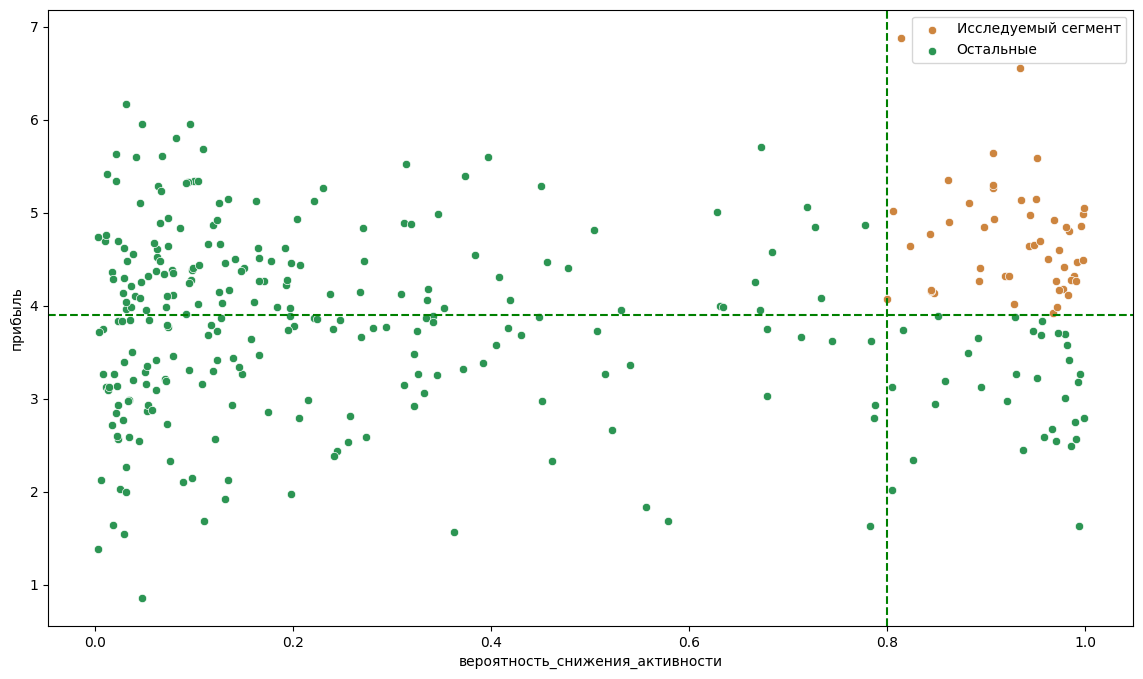

In [104]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=segmentation_df.query('сегмент == "исследуемый сегмент"'),
    x='вероятность_снижения_активности',
    y='прибыль',
    label='Исследуемый сегмент',
    color='peru')
sns.scatterplot(
    data=segmentation_df.query('сегмент != "исследуемый сегмент"'),
    x='вероятность_снижения_активности',
    y='прибыль',
    label='Остальные',
    color=sns.color_palette('BuGn_r')[1])
plt.axvline(x=0.8, color='green', linestyle='--')
plt.axhline(y=3.9, color='green', linestyle='--')
plt.show()

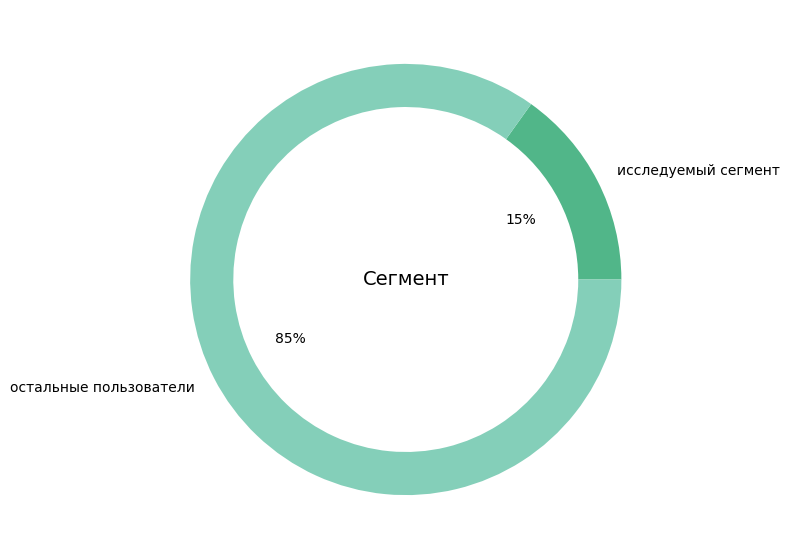

In [105]:
my_pie_plot(segmentation_df, 'сегмент')

Исследуемый сегмент занимает 15% от общей выборки.

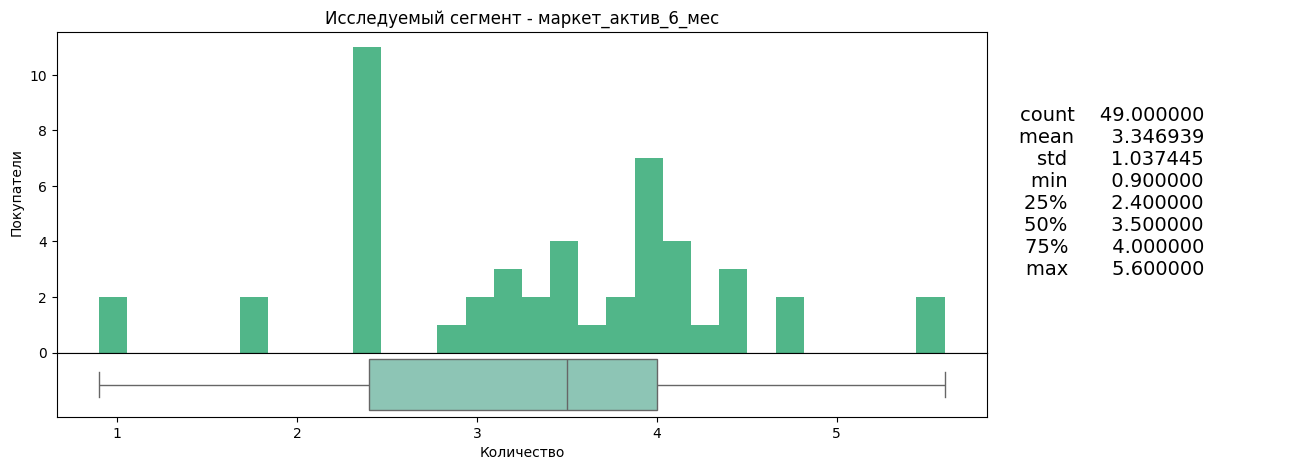

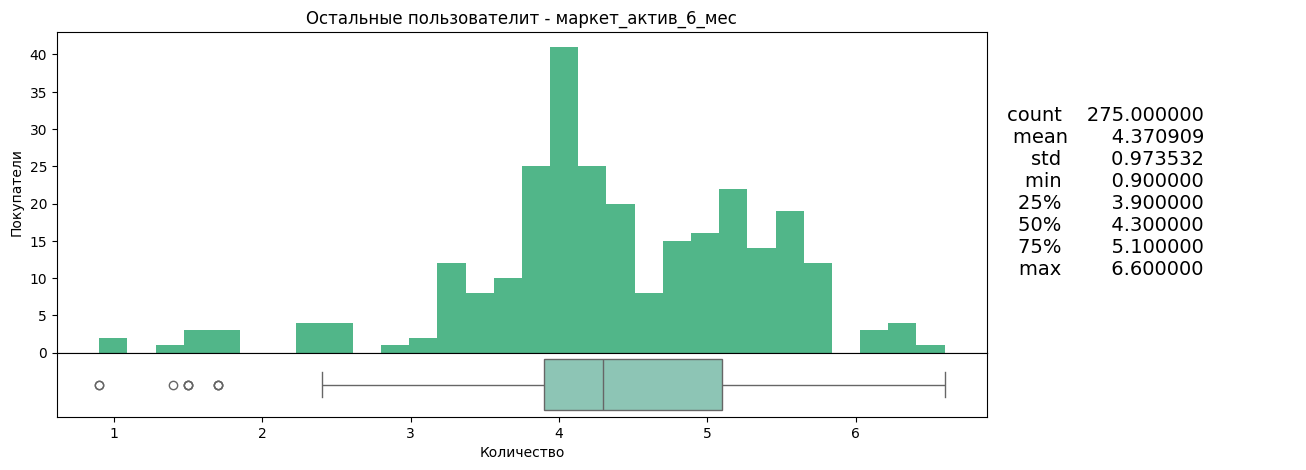

In [106]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'маркет_актив_6_мес', title='Исследуемый сегмент - маркет_актив_6_мес')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'маркет_актив_6_мес', title='Остальные пользователит - маркет_актив_6_мес')

На пользовавтелей из исследуемого сегмента приходиться в среднем на одну рассылку меньше чем на остальных пользователей.

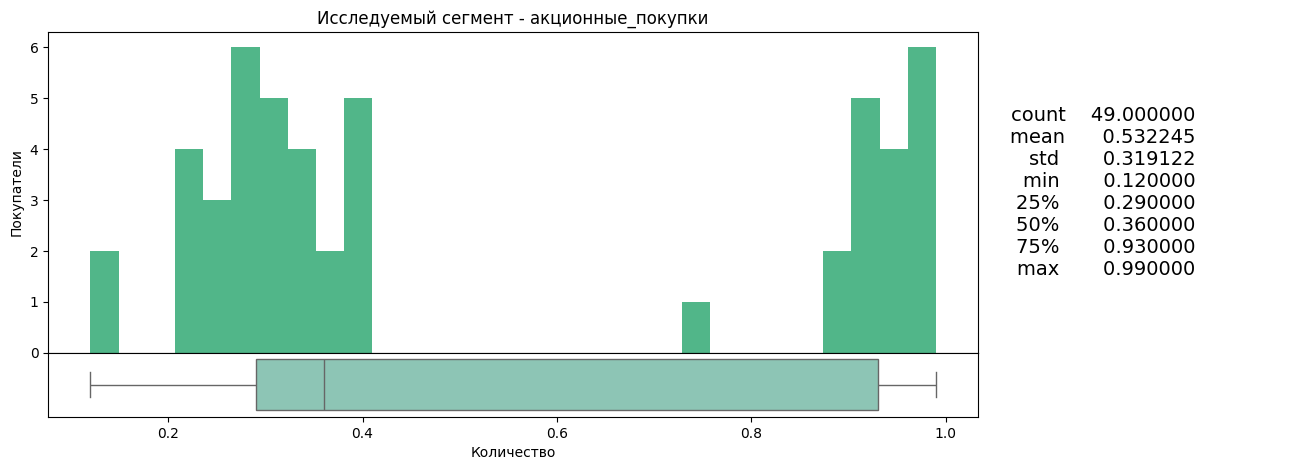

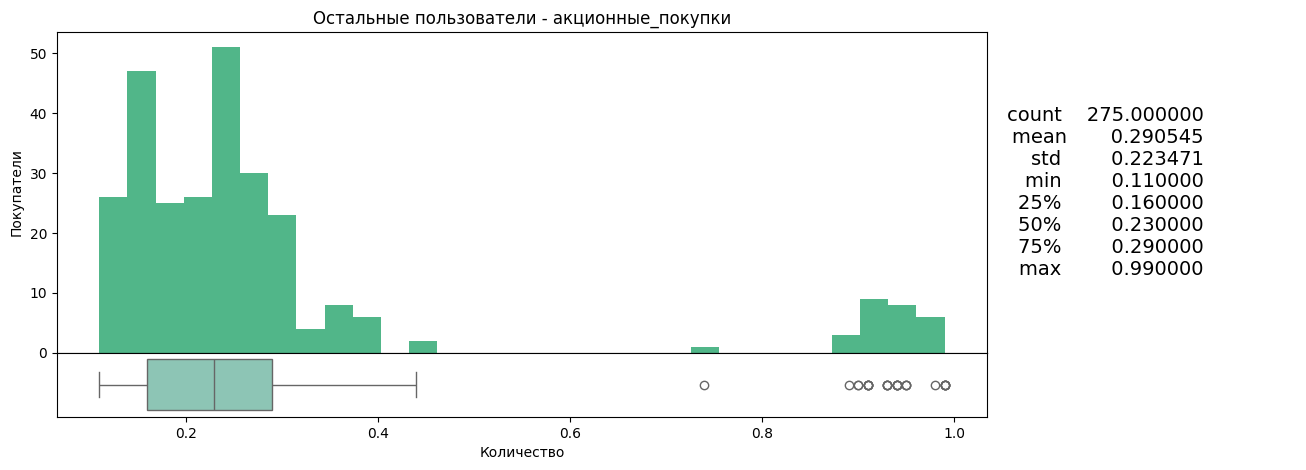

In [107]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'акционные_покупки', title='Исследуемый сегмент - акционные_покупки')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'акционные_покупки', title='Остальные пользователи - акционные_покупки')

Пользователи из исследуемого сегмента значительно чаще совершают покупки по акциям, рассчитаем долю таких пользователей в каждом сегменте:

In [108]:
frac_seg = (segmentation_df.query('сегмент == "исследуемый сегмент"')['акционные_покупки'] > 0.6).mean() * 100
frac_other = (segmentation_df.query('сегмент == "остальные пользователи"')['акционные_покупки'] > 0.6).mean() * 100
print(f'Доля пользователей из исследуемого сегмента совершивших акционные покупки: {int(frac_seg)}%')
print(f'Доля пользователей не из исследуемого сегмента совершивших акционные покупки: {int(frac_other)}%')

Доля пользователей из исследуемого сегмента совершивших акционные покупки: 36%
Доля пользователей не из исследуемого сегмента совершивших акционные покупки: 9%


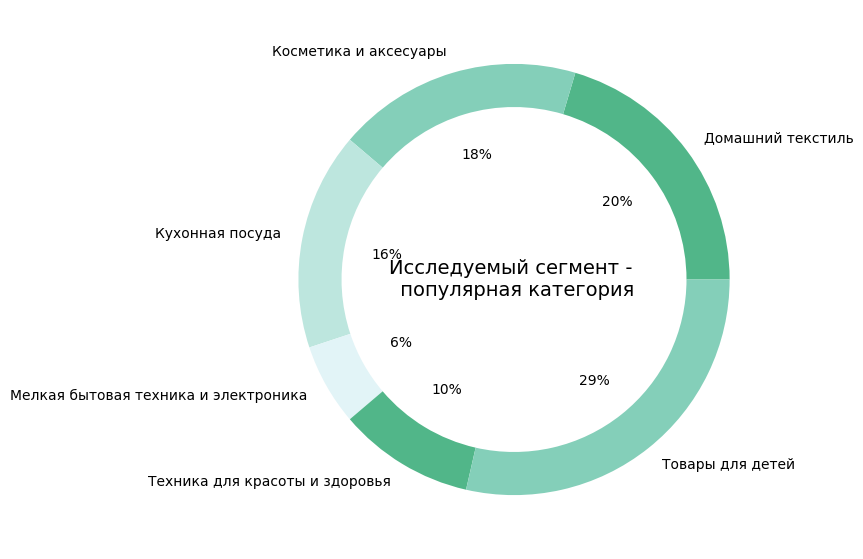

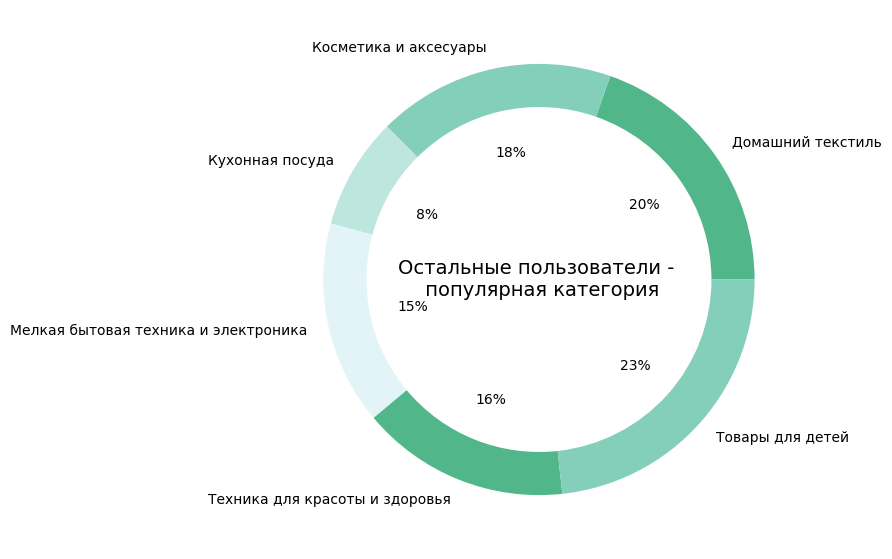

In [109]:
my_pie_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'популярная_категория', title='Исследуемый сегмент - \n популярная категория')
my_pie_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'популярная_категория', title='Остальные пользователи - \n популярная категория')

Люди из исследуемого сегмента на много чаще берут кухонную посуду и реже мелкую бытовую технику по сравнению с остальными пользователями.

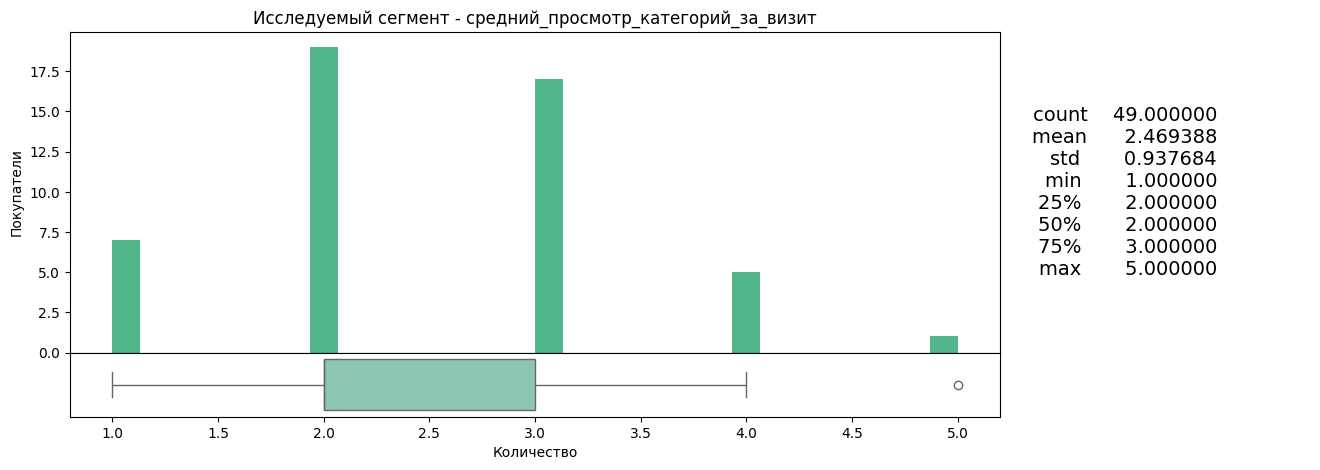

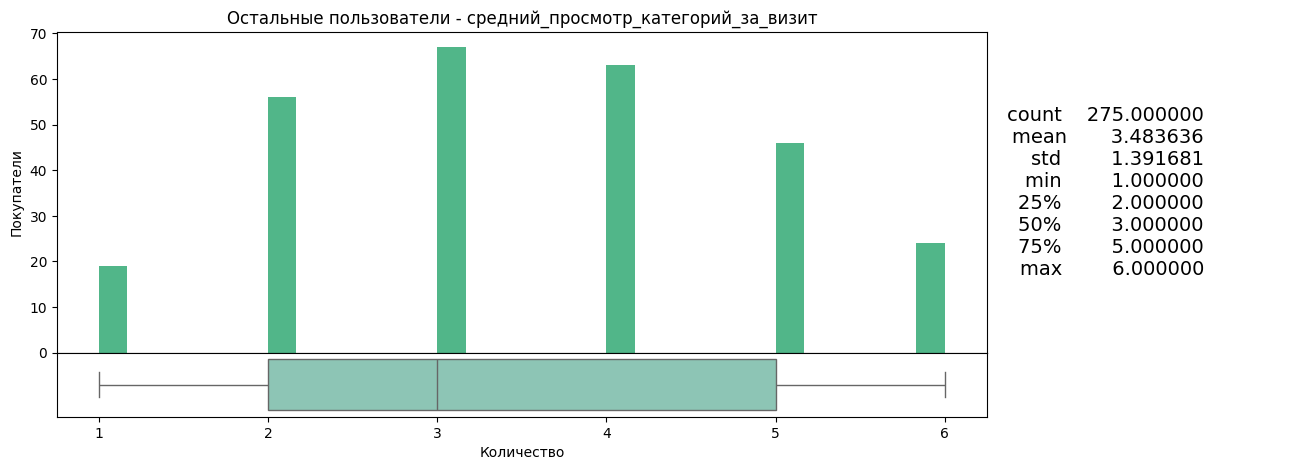

In [110]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'средний_просмотр_категорий_за_визит', title='Исследуемый сегмент - средний_просмотр_категорий_за_визит')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'средний_просмотр_категорий_за_визит', title='Остальные пользователи - средний_просмотр_категорий_за_визит')

Пользователи из исследуемого сегмента в среднем просматривают 2,5 категории за визит, а остальные по 3,5.

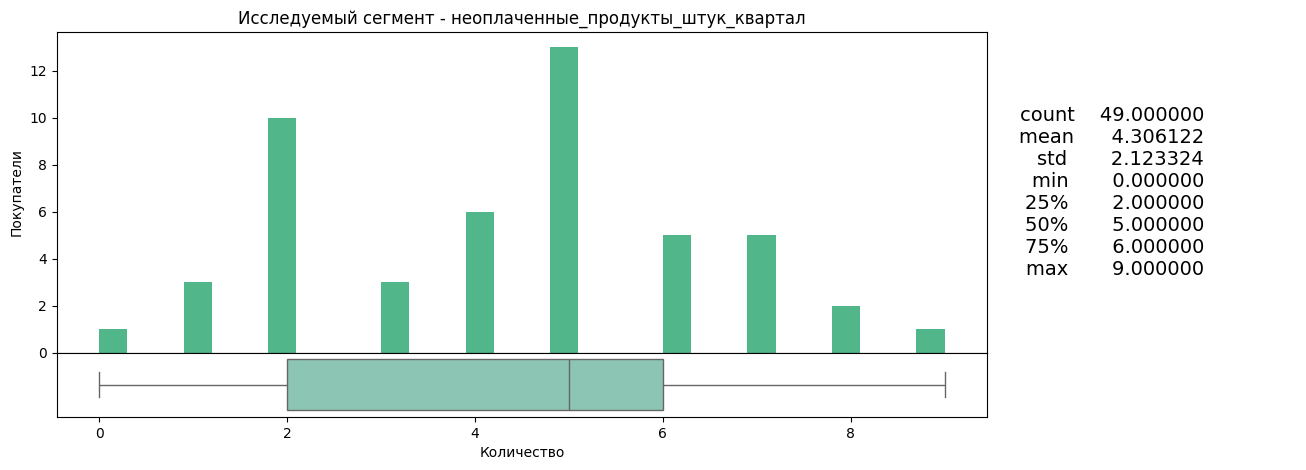

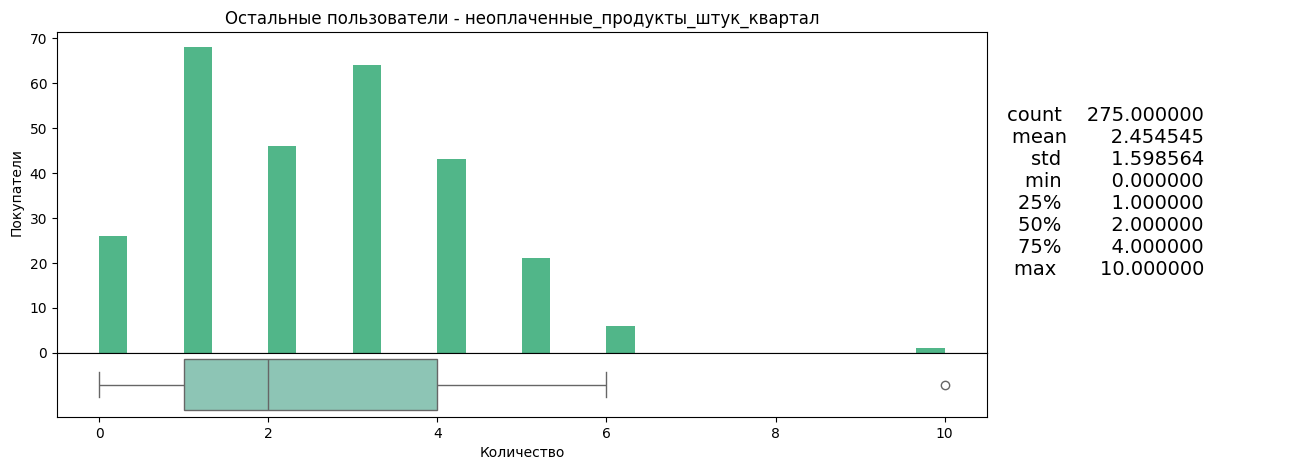

In [111]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'неоплаченные_продукты_штук_квартал', title='Исследуемый сегмент - неоплаченные_продукты_штук_квартал')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'неоплаченные_продукты_штук_квартал', title='Остальные пользователи - неоплаченные_продукты_штук_квартал')

Пользователи исследуемого сегмента намного чаще не оплачивают покупки, в среднем 4,3 против 2,45 у остальных покупателй.

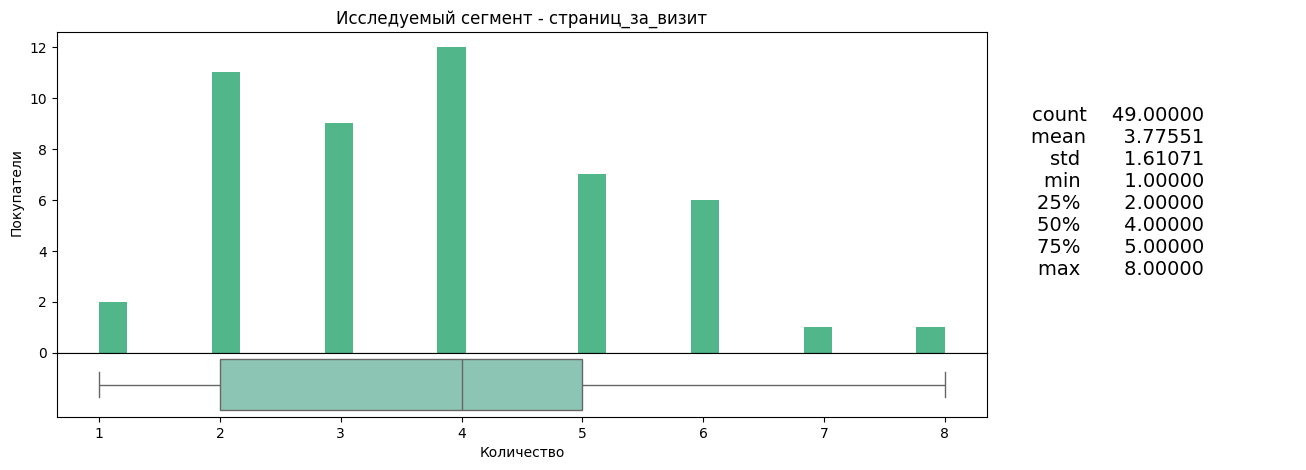

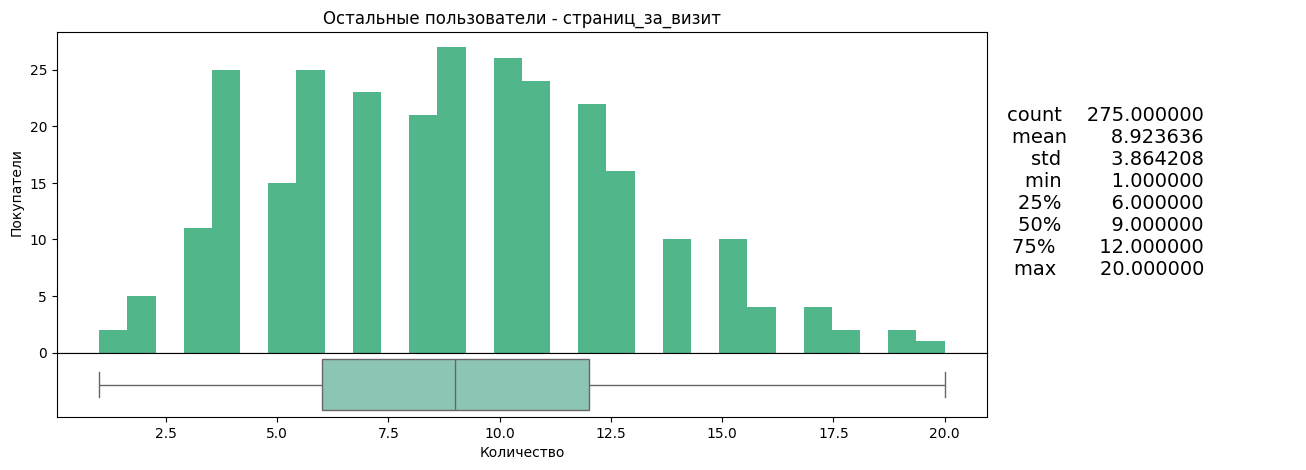

In [112]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'страниц_за_визит', title='Исследуемый сегмент - страниц_за_визит')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'страниц_за_визит', title='Остальные пользователи - страниц_за_визит')

Пользователи не входящие в исследуемый сегмент просматривают в 2,5 раза больше страниц, 8,92 в среднем, против 3,77.

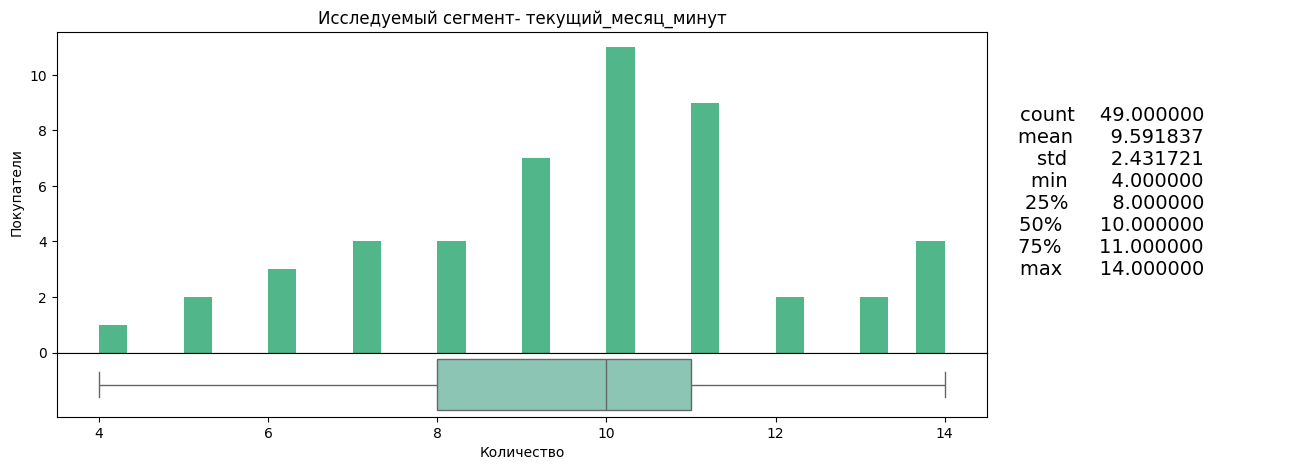

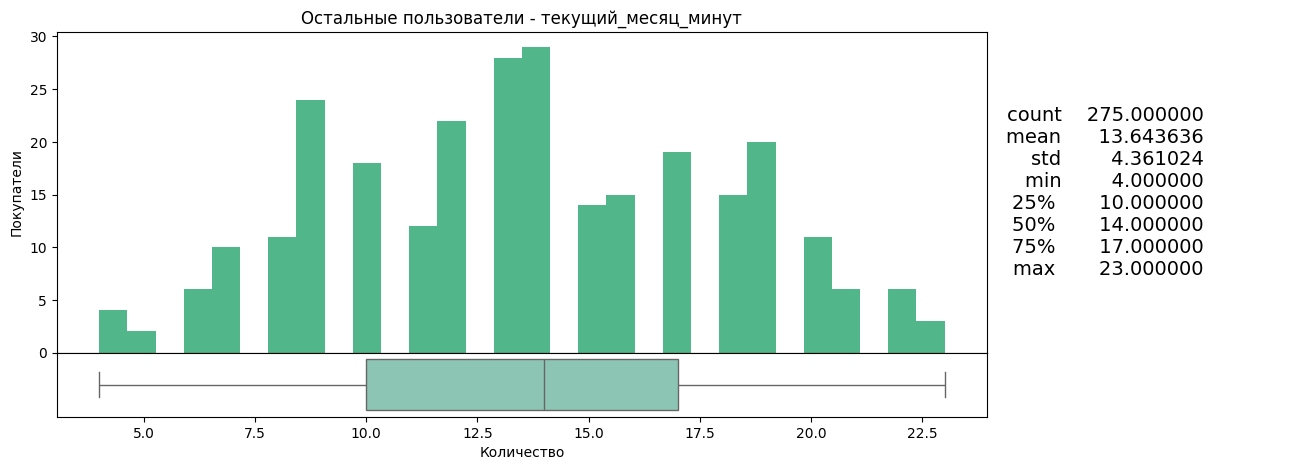

In [113]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'текущий_месяц_минут', title='Исследуемый сегмент- текущий_месяц_минут')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'текущий_месяц_минут', title='Остальные пользователи - текущий_месяц_минут')

Представители рассматриваемого сегмента, в среднем, на 4 минуты меньше проводят времени на сайте, чем остальные пользователи.

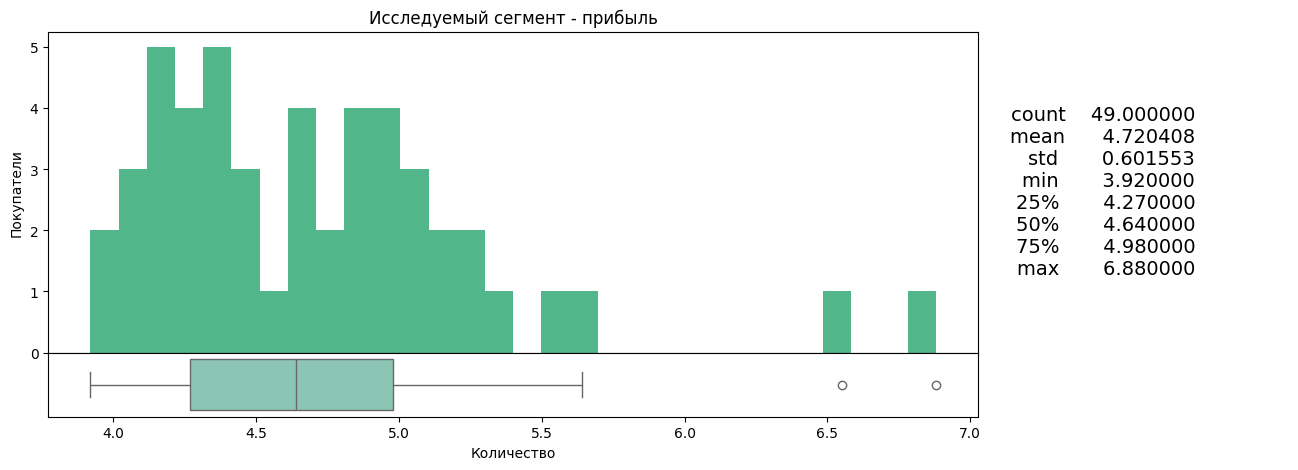

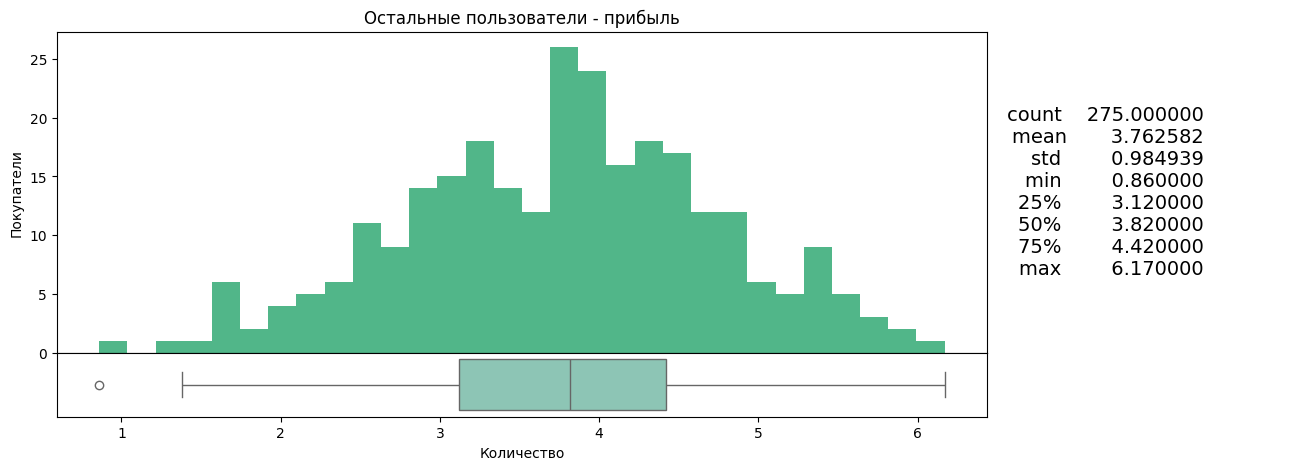

In [114]:
my_hist_plot(segmentation_df.query('сегмент == "исследуемый сегмент"'),
            'прибыль', title='Исследуемый сегмент - прибыль')
my_hist_plot(segmentation_df.query('сегмент == "остальные пользователи"'),
            'прибыль', title='Остальные пользователи - прибыль')

Средняя прибыль от пользователй исследуемого сегмента 4,72, у остальных пользователей 3,76 тыс. рублей.

### Вывод

На основе сравнительного анализа можно описать усредненный портрет двух групп пользователей, первая группа (исследуемый сегмент) - пользователи с высокой вероятностью снижения покупательской активности и высокой прибыльностью, вторая группа - это все остальные пользователи:

**Исследуемый сегмент:**
- Дает разрешение на получение сообщений
- Очень часто покупает товары для детей
- Редко покупает бытовую технику
- Просматривает 2-3 категории за визит
- Просматривает 3-4 страниц за визит
- Проводит 10 минут на сайте


**Остальные пользователи:**
- Дает разрешение на получение сообщений
- В равной степени часто покупает товары для детей и домашний текстиль
- Редко покупает кухонную посуду
- Просматривает 3-4 категории за визит
- Просматривает 8-9 страниц за визит
- Проводит 14 минут на сайте


**Другие характеристики:**
- У исследуемого сегмента доля премиум пользователей выше чем у неисследуемого, 35% против %28.
- На пользовавтелей из исследуемого сегмента приходиться в среднем меньше рассылок чем на остальных пользователй, 3,4 против 4,4.
- Маркетинговая активность в текущем месяце исследуемого сегмента и остальных пользователей сопоставима.
- Пользователи из исследуемого сегмента намного чаще пользуются акциями, в 36% случаев против 9%.
- Пользователи исследуемого сегмента чаще не оплачивают товары, в среднем 4,3 против 2,45 у остальных покупателй.

## Шаг 9. Общий вывод

Необходимо было разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого нужно было разработать модель для предсказания вероятностей снижения активности пользователей и на ее основе разобрать один из сегментов покупателей.

Были получены 4 таблицы:
- Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении - **market_file.csv**
- Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом - **market_money.csv**
- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода - **market_time.csv**
- Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю - **money.csv**

В ходе предобработки были утсранены опечатки, наименования признаков приведены в общий вид, была проведена проверка на дубликаты и пропуски.

Для поиска лучше модели был написан пайплайн, который перебрал 4 вида моделей (лоигистическая регрессия, дерево решений, k-ближайших соседей, метод опорных векторов) и их гиперпараметры, из данных поданных на обучения были удалены признаки не имеющие корреляции с целевым признаком по результату анализа корреляции матрицей phik. Основной метрикой был выбран recall, для минимизации ошибки второго типа, необходимой для решения бизнес задачи.

Лучшая модель получилась следующей:

*LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')*

По результату обучения на тестовой выбоки получились следующие метрики:
- recall: 0.82
- accuracy: 0.91
- f1: 0.87
- roc_auc: 0.92
- precision: 0.93

Покупатели с высокой вероятностью снижения покупательской активности и высокой прибыльностью, ведут себя иначе чем остальные пользователти, они смотрят меньше категорий, просматривают меньше страниц, редко покупают бытовую технику и электронику, часто, чаще чем остальные пользователи, берут кухонные товары. Среди таких покупателей доля акционных товаров в 4 раза выше чем у остальных пользователей. Так же они чаще имеют подписку премиум, видимо для получения большей выгоды и новых акций. Для сохранения преждней активности данных покупателей, следут увеличить маркетинговую активность, и рассылку макретинговых предложений, необходимо увеличить их вовлеченность, чтобы они дольше задерживались на сайте и чаще предлогать им разнообразные категори товаров и акции.